# Trabajo Práctico N°2 
Asignatura: Minería de Datos.

Carrera: Tecnicatura Universitaria en Inteligencia Artificial.

Año: 2024.

Integrante: López Ceratto, Julieta.

# Librerias a utilizar

In [651]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import silhouette_score,silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, cohen_kappa_score
from sklearn.naive_bayes import GaussianNB,  MultinomialNB, BernoulliNB
from sklearn import metrics
import random
from sklearn.preprocessing import LabelEncoder
import warnings

# Ignorar todas las advertencias
warnings.filterwarnings("ignore")

# Funciones

In [652]:
def plot_multiple_conf_matrices(y_real_list, y_pred_list, titles):      
    num_matrices = len(y_real_list)
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    # Lista de colormaps para seleccionar aleatoriamente
    colormaps = ['Blues', 'Greens', 'Reds', 'Purples', 'Oranges', 'coolwarm', 'cividis', 'magma']
    for i in range(num_matrices):
        color = random.choice(colormaps)
        cm = metrics.confusion_matrix(y_real_list[i], y_pred_list[i])
        sns.heatmap(cm, annot=True, ax=axes[i], fmt='d', cmap=color)
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Predicted labels')
        axes[i].set_ylabel('True labels')

    # Oculta cualquier eje restante si hay menos de 4 matrices
    for j in range(num_matrices, 4):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [653]:
def pd_metricas_clasifier(dict_modelos:dict, m_type: str = 'clasifier'):
    metricas_modelos = pd.DataFrame()    
    for key,value in dict_modelos.items():
        valores_modelo = value[0]
        metrica_clas = {
        'Nombre_Modelo': key,
        'Max_profundidad' : valores_modelo[0],
        'Min_obs' : valores_modelo[1],
        'Min_Obs_x_Sep' : valores_modelo[2],
        'Criterio_Sep' : valores_modelo[3]
        }
        if m_type == 'clasifier':
            for i in range(1,len(value)):
                y_real,y_pred = value[i]
                metrica_clas[f'Precision Test {i}'] = precision_score(y_real,y_pred, pos_label=0, average='weighted'),
                metrica_clas[f'Recall Test {i}'] = recall_score(y_real,y_pred, pos_label=0, average='weighted')
                metrica_clas[f'Accuracy Test {i}'] = accuracy_score(y_real,y_pred),
                metrica_clas[f'F1-Score Test {i}'] = f1_score(y_real,y_pred, pos_label=0, average='weighted')
        elif m_type == 'regressor':
            for i in range(1,len(value)):
                y_real,y_pred = value[i]
                metrica_clas[f'MAE Test {i}'] = mean_absolute_error(y_real,y_pred),
                metrica_clas[f'MSE Test {i}'] = mean_squared_error(y_real,y_pred)
                metrica_clas[f'RMSE Test {i}'] = np.sqrt(mean_squared_error(y_real,y_pred)),
        metricas_modelos = pd.concat([metricas_modelos,pd.DataFrame(metrica_clas)])
    
    return metricas_modelos

In [654]:
def plot_tree(regressor_t, features):
    plt.figure(figsize=(14,6))
    tree.plot_tree(regressor_t[1], feature_names=features, fontsize=8, filled=True,
                rounded=True)
    plt.show()

# Carga de datos

In [655]:
df = pd.read_csv('./src/1000_Companies.csv')

In [656]:
df

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.800,471784.1000,New York,192261.83000
1,162597.70,151377.590,443898.5300,California,191792.06000
2,153441.51,101145.550,407934.5400,Florida,191050.39000
3,144372.41,118671.850,383199.6200,New York,182901.99000
4,142107.34,91391.770,366168.4200,Florida,166187.94000
...,...,...,...,...,...
995,54135.00,118451.999,173232.6695,California,95279.96251
996,134970.00,130390.080,329204.0228,California,164336.60550
997,100275.47,241926.310,227142.8200,California,413956.48000
998,128456.23,321652.140,281692.3200,California,333962.19000


# Punto 1

## Análisis descriptivo

In [657]:
## Cantidad de columnas y sus tipos de datos
print(f'El DataFrame cuenta con un total de {len(df.columns)} columnas:')
df.dtypes

El DataFrame cuenta con un total de 5 columnas:


RyD_Spend         float64
Administration    float64
MarketingSpend    float64
State              object
Profit            float64
dtype: object

In [658]:
print(f'Cada columna se comporta de la siguiente manera:')
df.describe()

Cada columna se comporta de la siguiente manera:


,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


- RyD_Spend: Toma valores desde 0,0 a 165.349, su promedio es de 81.669 y su mediana de 79.936, lo que infiere que no tiene presencia de atípicos.
- Administración: Toma valores desde 51.283 a 321.652, su promedio es de 122.963 y su mediana de 122.421, lo que infiere que no tiene presencia de atípicos. Esta variable posee un mayor RIC que la anterior.
- MarkentingSpend: Toma valores desde 0,0 a 471784, su promedio es de 226.205 y su mediana de 224.517, lo que infiere que no tiene presencia de atípicos.
- Profit: Toma valores desde 14.681 a 476.485, su promedio es de 119.546 y su mediana de 117.641, lo que infiere que no tiene presencia de atípicos.

Si se quiere ver en histograma:


array([[<Axes: title={'center': 'RyD_Spend'}>,
        <Axes: title={'center': 'Administration'}>],
       [<Axes: title={'center': 'MarketingSpend'}>,
        <Axes: title={'center': 'Profit'}>]], dtype=object)

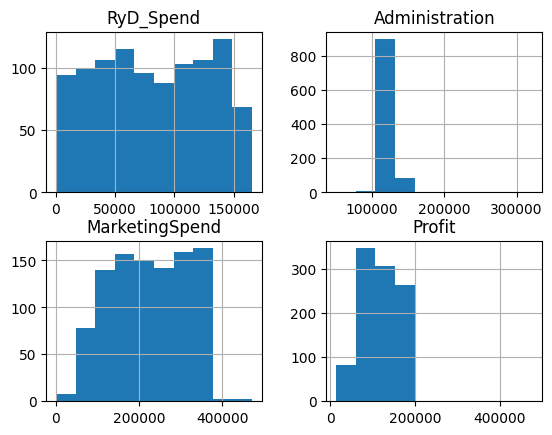

In [659]:
print(f'Si se quiere ver en histograma:')
df.hist()

<Axes: xlabel='State', ylabel='Count'>

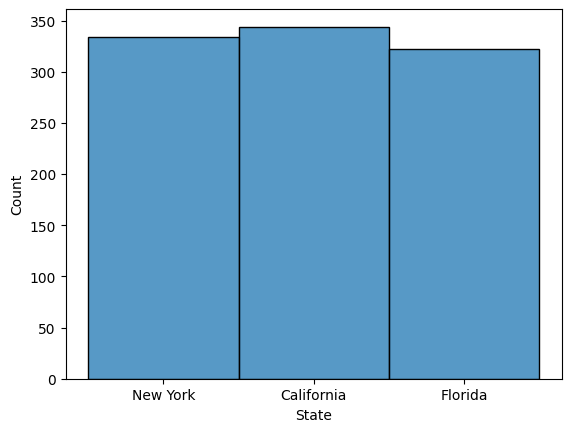

In [660]:
sns.histplot(df['State'])

Se puede ver que las variables RyD_Spend, MarketingSpend y Profit tienen una distribución uniforme, sin la presencia de atípicos visibles.

Por otro lado, en cuanto a la varibale Administración, la misma se concentra casi en su totalidad en el valor 900 aproximado, teniendo algunos caos atípicos en 100 a su derecha y cercanos a 0 a la izquierda.

<Axes: >

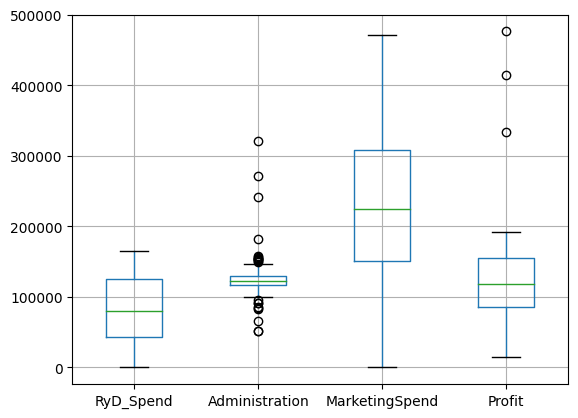

In [661]:
##Vemos la distribución en forma de boxplot
df.boxplot()

Podemos ver que las inferencias acerca de los atípicos en el primer bloque se confirman para las variables de RyD_Spend y Marketing_Spend, sin embargo, no para la variable de Administration ya que esto sólo era visible mediante boxplot. Esto se debe a que posee atípicos tanto por encima como por debajo de Q3 y Q1 respectivamente.
Profit solo tiene 3 atípicos por encima de su Q3.

Por otro lado, podemos observar que la variable MarketingSpend tiene una varianza mucho más notable que el resto, mientras que Profit y RyD_Spend se manejan con varianzas similares; finalmente, Administration -como ya se dejaba ver en el histograma- tiene una varianza muy pequeña.

Para terminar de confirmar si son atípicos, observamos las mismas variables diferenciadas ahora por la columna 'State":

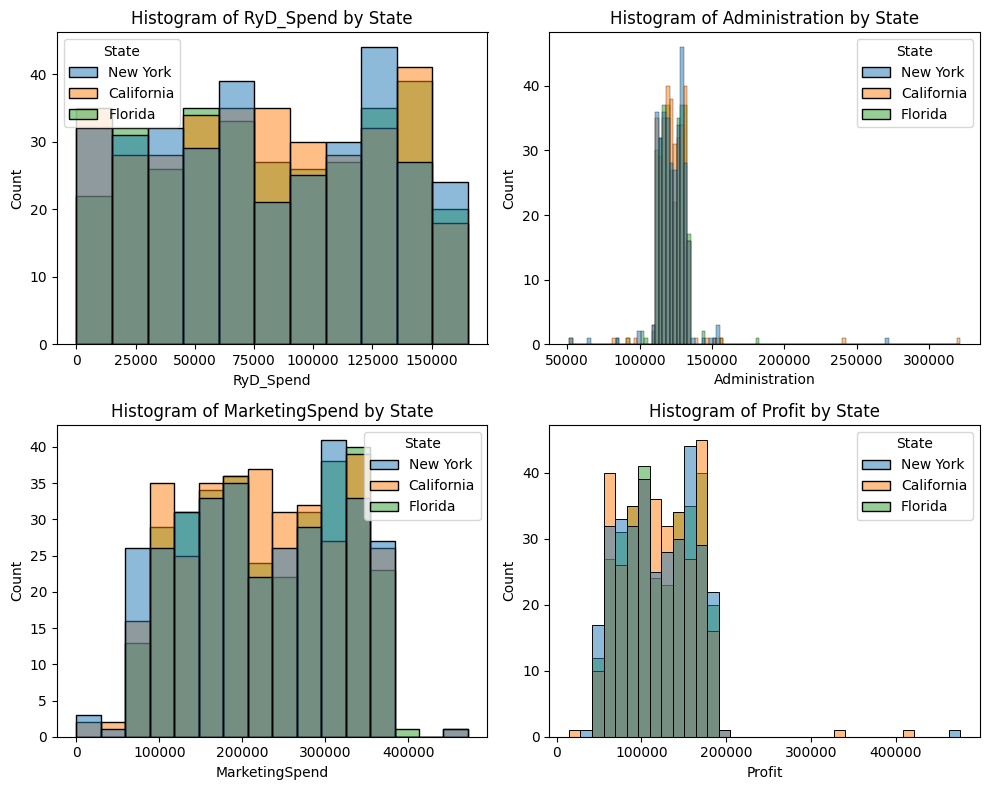

In [662]:
# Selecciona solo las columnas numéricas
numeric_columns = df.select_dtypes(include='number').columns

# Configura el tamaño del grid: 2 gráficos por fila
fig, axes = plt.subplots(len(numeric_columns) // 2 + len(numeric_columns) % 2, 2, figsize=(10, len(numeric_columns) * 2))

# Aplanar la matriz de axes para recorrer más fácilmente
axes = axes.flatten()

# Itera sobre las columnas numéricas y grafica los histogramas
for i, col in enumerate(numeric_columns):
    sns.histplot(data=df, x=col, hue='State', kde=False, ax=axes[i])
    axes[i].set_title(f'Histogram of {col} by State')

# Elimina gráficos extra si hay un número impar de columnas
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Podemos confirmar que se tratan de atípicos ya que no hay tendencias de comportamiento para un estado específico que sugieran que esos valores atípicos sean en realidad parte normal de los valores para un estado en específico. Los 3 valores atípicos vistos en la variable 'Profit' podrían quitarse sin problemas ya que no representan un gran número en comparación con el resto de datos.

### Presencia de Null

In [663]:
df.isnull().any()

RyD_Spend         False
Administration    False
MarketingSpend    False
State             False
Profit            False
dtype: bool

## Observación del balanceado

In [664]:
df['State'].value_counts()

State
California    344
New York      334
Florida       322
Name: count, dtype: int64

Se puede observar que el df se encuentra relativamente balanceado, siendo la máxima diferencia entre una clase y otra de 24 filas, lo que en un dataframe de 1000 no es una representación muy grande.

## Correlación.

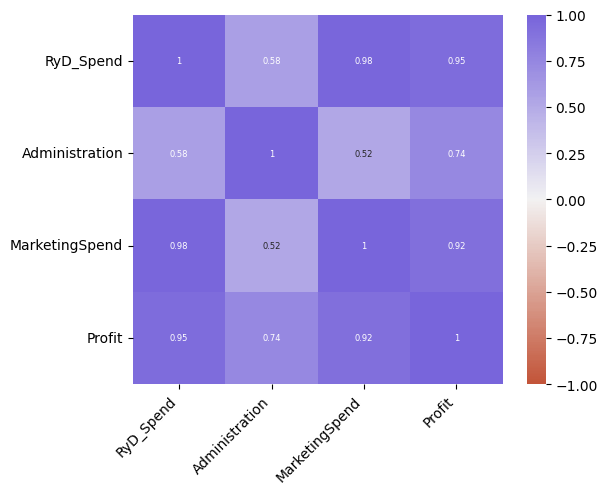

In [665]:
corr = df.drop(columns='State').corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 270, n=300),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

Las variables más correlacionadas entre sí son:
- RyD_Spend - Profit: tienen una correlación casi lineal (0.95 positiva).
- MarketingSpend - Profit: correlación positiva de 0.92, casi lineal.
- Administration - Profit: 0.74 positiva, es también una correlación fuerte.

La correlación más baja es de 0.52 positiva entre Administrattion y MarketingSpend.

En general, hay correlaciones bastante fuertes entre las variables.

No hay presencia de correlaciones negativas.

## Estandarización

### Division train-test

In [666]:
df_encoded = pd.get_dummies(df, columns=['State'], drop_first=True)

In [667]:
df_encoded

,RyD_Spend,Administration,MarketingSpend,Profit,State_Florida,State_New York
0,165349.20,136897.800,471784.1000,192261.83000,False,True
1,162597.70,151377.590,443898.5300,191792.06000,False,False
2,153441.51,101145.550,407934.5400,191050.39000,True,False
3,144372.41,118671.850,383199.6200,182901.99000,False,True
4,142107.34,91391.770,366168.4200,166187.94000,True,False
...,...,...,...,...,...,...
995,54135.00,118451.999,173232.6695,95279.96251,False,False
996,134970.00,130390.080,329204.0228,164336.60550,False,False
997,100275.47,241926.310,227142.8200,413956.48000,False,False
998,128456.23,321652.140,281692.3200,333962.19000,False,False


In [668]:
X = df_encoded.drop(columns='Profit')
y = df_encoded['Profit']

In [669]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
#Segunda division para predecir sobre segundo conjunto test
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.4, random_state=1)

In [670]:
features = list(X.columns)

In [671]:
features

['RyD_Spend',
 'Administration',
 'MarketingSpend',
 'State_Florida',
 'State_New York']

El método de standarización elegido es StandarScaler para las columnas numéricas.

In [672]:
y_train.shape

(800,)

In [673]:
X_train.shape, X_test.shape, X_test_2.shape

((800, 5), (200, 5), (400, 5))

# Punto 2 : Árbol de decisión (Regresión)

Realizar la estimación del atributo Profit utilizando árboles de decisión (Regresión)
analizando los parámetros máximo profundidad, número mínimo de observaciones,
número mínimo de observaciones por separación y criterio de separación. Graficar el árbol
obtenido en el proceso de entrenamiento y mostrar los resultados sobre dos conjuntos de
test (Error Absoluto Medio, Error Cuadrático Medio y Raíz del Error Cuadrático Medio).

In [674]:
regressor_tree = make_pipeline(StandardScaler() ,tree.DecisionTreeRegressor( max_depth=5,min_samples_split= 5, min_samples_leaf=5 ,random_state=23) )

In [675]:
regressor_tree.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=5, min_samples_leaf=5,
                                       min_samples_split=5, random_state=23))])

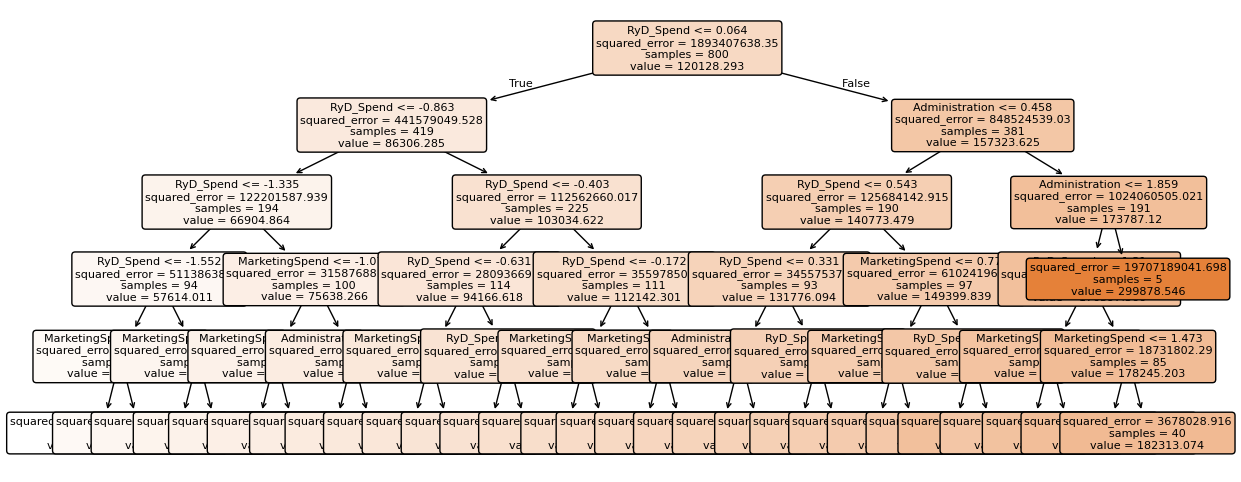

In [676]:
plot_tree(regressor_tree, features)

In [677]:
# Predicción en el conjunto de entrenamiento
y_pred_a = regressor_tree.predict(X_test)
y_pred_b = regressor_tree.predict(X_test_2)

## Variando parametros manualmente

### 2

In [678]:
regressor_tree_2 = make_pipeline(StandardScaler(),tree.DecisionTreeRegressor( max_depth=3,min_samples_split= 5, min_samples_leaf=5 ,random_state=24) )

In [679]:
regressor_tree_2.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=3, min_samples_leaf=5,
                                       min_samples_split=5, random_state=24))])

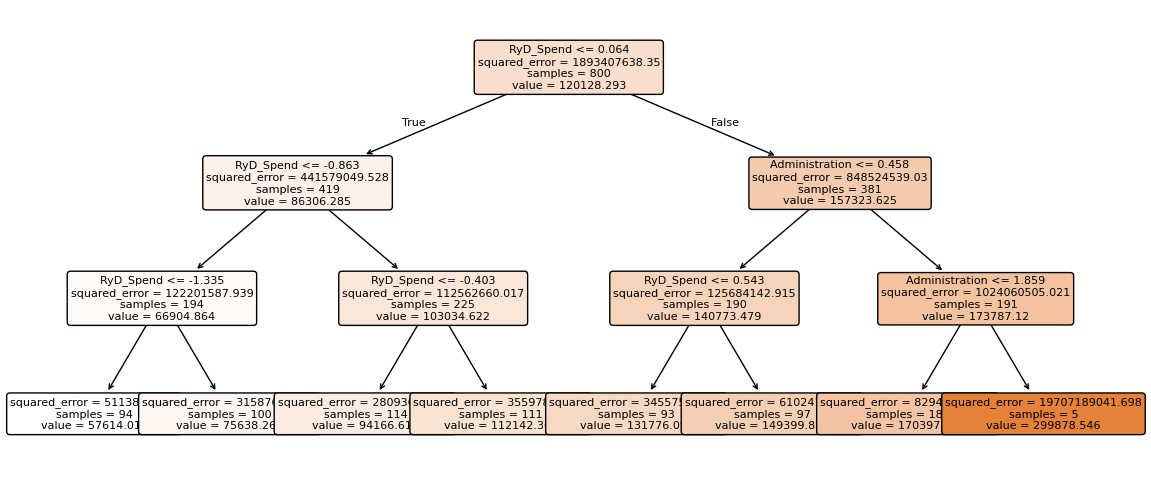

In [680]:
plot_tree(regressor_tree_2, features)

In [681]:
# Predicción en el conjunto de entrenamiento
y_pred_2_a = regressor_tree_2.predict(X_test)
y_pred_2_b = regressor_tree_2.predict(X_test_2)

### 3

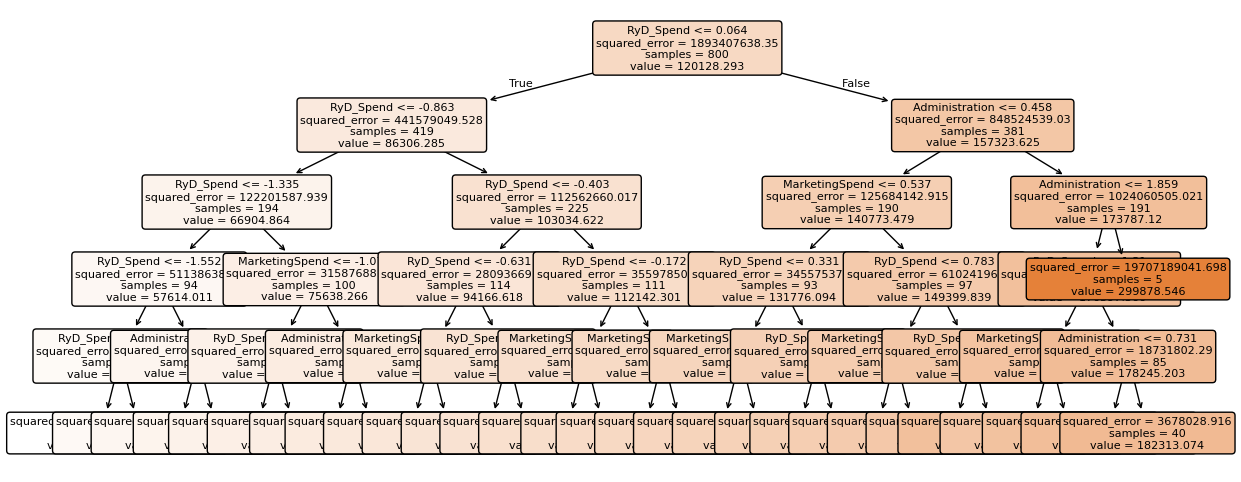

In [682]:
regressor_tree_3 = make_pipeline(StandardScaler(),tree.DecisionTreeRegressor( max_depth=5,min_samples_split= 10, min_samples_leaf=5 ,random_state=25) )
regressor_tree_3.fit(X_train,y_train)
plot_tree(regressor_tree_3, features)
# Predicción en el conjunto de entrenamiento
y_pred_3_a = regressor_tree_3.predict(X_test)
y_pred_3_b = regressor_tree_3.predict(X_test_2)

### 4

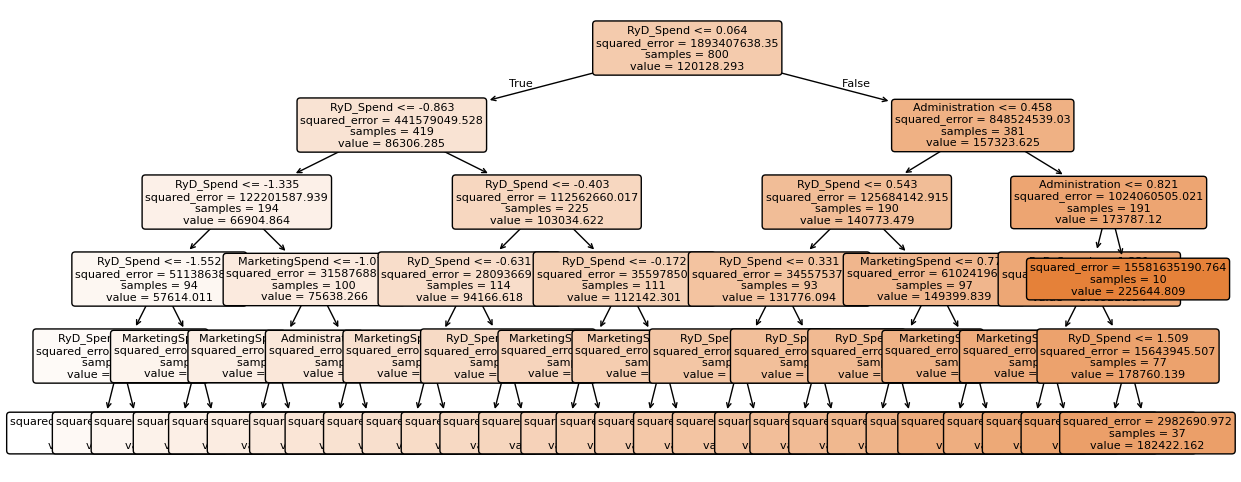

In [683]:
regressor_tree_4 = make_pipeline(StandardScaler(),tree.DecisionTreeRegressor( max_depth=5,min_samples_split= 5, min_samples_leaf=10 ,random_state=26) )
regressor_tree_4.fit(X_train,y_train)
plot_tree(regressor_tree_4, features)
# Predicción en el conjunto de entrenamiento
y_pred_4_a = regressor_tree_4.predict(X_test)
y_pred_4_b = regressor_tree_4.predict(X_test_2)

## Metricas

In [684]:
dic_modelos_regressor_tree = {
    'Regressor_tree' : [[5,5,5,'SQR'], (y_test,y_pred_a),(y_test_2,y_pred_b)],
    'Regressor_tree 2' : [[3,5,5,'SQR'], (y_test,y_pred_2_a),(y_test_2,y_pred_2_b)],
    'Regressor_tree 3' : [[5,10,5,'SQR'], (y_test,y_pred_3_a),(y_test_2,y_pred_3_b)],
    'Regressor_tree 4' : [[5,5,10,'SQR'], (y_test,y_pred_4_a),(y_test_2,y_pred_4_b)],
}

In [685]:
metricas = pd_metricas_clasifier(dic_modelos_regressor_tree, 'regressor')

### Metricas con cada intento

In [686]:
metricas

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,MAE Test 1,MSE Test 1,RMSE Test 1,MAE Test 2,MSE Test 2,RMSE Test 2
0,Regressor_tree,5,5,5,SQR,3075.802458,2.041276e+08,14287.324459,3266.928119,2.465184e+08,15700.905655
0,Regressor_tree 2,3,5,5,SQR,6805.059519,2.410551e+08,15525.950449,7140.482160,2.940450e+08,17147.740915
0,Regressor_tree 3,5,10,5,SQR,3143.214182,2.060672e+08,14355.040392,3266.928119,2.465184e+08,15700.905655
0,Regressor_tree 4,5,5,10,SQR,2421.245971,6.041965e+07,7773.007906,3591.658042,2.238199e+08,14960.611635


### Análisis de Influencia de los Parámetros

**Max_Profundidad (Profundidad del árbol):**

Regressor_tree (Profundidad 5) y Regressor_tree_3 (Profundidad 5) tienen el mismo valor para este parámetro. Sus MAE y MSE son relativamente similares (3075.80 y 3143.21 para MAE).

Regressor_tree_2 (Profundidad 3) muestra un aumento significativo en el MAE (6805.06). Esto sugiere que reducir la profundidad del árbol puede resultar en un modelo que no captura adecuadamente la complejidad de los datos, llevando a un mayor error.
Una mayor profundidad generalmente permite al modelo capturar patrones más complejos, pero también puede aumentar el riesgo de sobreajuste.


**Min_Obs (Mínimo de observaciones para una hoja):**

Regressor_tree (5) y Regressor_tree_4 (5) tienen el mismo valor para este parámetro, pero Regressor_tree_4 reduce el mínimo de observaciones por separación (10). Esto resulta en un MAE más bajo (2421.25).

Un menor número de observaciones en una hoja (hojas más "delgadas") puede permitir que el modelo se ajuste más a los datos, resultando en menor error, pero también puede aumentar el riesgo de sobreajuste si se hace excesivamente.


**Min_Obs_x_Sep (Mínimo de observaciones por separación):**

Al comparar Regressor_tree_3 (Min_Obs_x_Sep=5) y Regressor_tree_4 (Min_Obs_x_Sep=10), se observa que aumentar este parámetro en el último modelo reduce significativamente el MAE a 2421.25. Esto sugiere que tener más observaciones requeridas por cada separación puede ayudar a crear divisiones más robustas, resultando en un modelo más generalizable y menos propenso a sobreajuste.


**Criterio_Sep (Criterio de separación):**

En este caso, todos los modelos utilizan el criterio de separación "SQR" (suma de los cuadrados de los residuos). No se pueden comparar directamente otros criterios en este caso, pero cambiar este parámetro en otros escenarios puede afectar la forma en que se construye el árbol.

### **Resumen de Influencias**

Profundidad del árbol: Profundidades más altas tienden a captar patrones más complejos, pero pueden resultar en sobreajuste. Una profundidad demasiado baja puede no capturar la complejidad del problema.

Mínimo de observaciones: Un valor menor permite más flexibilidad en el ajuste del modelo, pero con el riesgo de sobreajuste. Aumentar el número de observaciones por separación tiende a mejorar la generalización del modelo.

Métricas de error: Un MAE, MSE y RMSE más bajos indican un mejor rendimiento del modelo. En este caso, Regressor_tree_4 parece ser el modelo más eficiente, con los errores más bajos, sugiriendo que un equilibrio entre profundidad del árbol y número mínimo de observaciones por separación puede llevar a mejores resultados.

## Optimización de hiperparámetros

In [687]:
escal = StandardScaler()
X_train_scaled = escal.fit_transform(X_train)

In [688]:
param_grid = {
    'max_features': [3, 5, 6, 7, 9],
    'max_depth': [6, 9, 10, 11],
    'min_samples_split' : [3,5,10,20,30],
    'min_samples_leaf' : [3,5,10,15,20 ]
}
random_search = GridSearchCV(tree.DecisionTreeRegressor(),
                                   param_grid)

random_search.fit(X_train_scaled, y_train)


GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [6, 9, 10, 11],
                         'max_features': [3, 5, 6, 7, 9],
                         'min_samples_leaf': [3, 5, 10, 15, 20],
                         'min_samples_split': [3, 5, 10, 20, 30]})

In [689]:
#veo mejores parámetros encontrados
random_search.best_params_

{'max_depth': 6,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 10}

In [690]:
best_prediction = make_pipeline(StandardScaler(), tree.DecisionTreeRegressor(max_depth = 11, max_features=3, min_samples_leaf=3, min_samples_split=3, random_state=7))

In [691]:
best_prediction.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=11, max_features=3,
                                       min_samples_leaf=3, min_samples_split=3,
                                       random_state=7))])

In [692]:
## Hago predicciones test
best_prediction_a = best_prediction.predict(X_test)
best_prediction_b = best_prediction.predict(X_test_2)

In [693]:
dic_best_regressor = {
    'Best Regressor Tree' : [[11,3,3,'SQL'], (y_test, best_prediction_a), (y_test_2, best_prediction_b)]
}

In [694]:
metricas = pd.concat([metricas, pd_metricas_clasifier(dic_best_regressor, 'regressor')])

In [695]:
metricas

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,MAE Test 1,MSE Test 1,RMSE Test 1,MAE Test 2,MSE Test 2,RMSE Test 2
0,Regressor_tree,5,5,5,SQR,3075.802458,2.041276e+08,14287.324459,3266.928119,2.465184e+08,15700.905655
0,Regressor_tree 2,3,5,5,SQR,6805.059519,2.410551e+08,15525.950449,7140.482160,2.940450e+08,17147.740915
0,Regressor_tree 3,5,10,5,SQR,3143.214182,2.060672e+08,14355.040392,3266.928119,2.465184e+08,15700.905655
0,Regressor_tree 4,5,5,10,SQR,2421.245971,6.041965e+07,7773.007906,3591.658042,2.238199e+08,14960.611635
0,Best Regressor Tree,11,3,3,SQL,1128.375267,1.282685e+07,3581.459269,786.475305,1.136332e+07,3370.952868


El modelo ajustado con los mejores parámetros claramente supera a los otros modelos en todos los aspectos clave (MAE, MSE, y RMSE). Esto indica que la optimización de los hiperparámetros ha resultado en un modelo mucho más eficiente y preciso para este conjunto de datos.

El ajuste de los parámetros como max_depth y max_features ha mejorado significativamente el rendimiento del modelo, reduciendo los errores y proporcionando mejores predicciones generales. Al reducir la profundidad, se evita que el modelo sobreajuste y, al reducir la cantidad de features que haga un underfitting; encontrar la armonía entre estos dos hiperparámetros permite que el modelo generalice de forma correcta.

Sin embargo, cabe destacar que se ve una performance ampliamente diferente entre los distintos conjuntos de Test.

# Punto 3

Carga de datos

In [696]:
df_pokemon = pd.read_csv('./src/PokemonDBCart.csv')
df_pokemon

,Nombre,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa,TipoPokemon
0,Bulbasaur,49,49,45,45,65,65,hierba
1,Ivysaur,62,63,60,60,80,80,hierba
2,Venusaur,100,123,80,80,122,120,hierba
3,Charmander,52,43,65,39,60,50,fuego
4,Charmeleon,64,58,80,58,80,65,fuego
...,...,...,...,...,...,...,...,...
474,Buzzwole,139,139,79,107,53,53,bicho
475,Pheromosa,137,37,151,71,137,37,bicho
476,Xurkitree,89,71,83,83,173,71,electrico
477,Kartana,181,131,109,59,59,31,hierba


## Análisis descriptivo

## Tipos de datos

In [697]:
## Cantidad de columnas y sus tipos de datos
print(f'El DataFrame cuenta con un total de {len(df_pokemon.columns)} columnas:')
df_pokemon.dtypes

El DataFrame cuenta con un total de 8 columnas:


Nombre         object
Ataque          int64
Defensa         int64
Velocidad       int64
HP              int64
SpAtaque        int64
SpDefensa       int64
TipoPokemon    object
dtype: object

## Distribuciones y Atípicos.

In [698]:
print(f'Cada columna se comporta de la siguiente manera:')
df_pokemon.describe()

Cada columna se comporta de la siguiente manera:


,Ataque,Defensa,Velocidad,HP,SpAtaque,SpDefensa
count,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000
mean,73.956159,70.657620,66.377871,66.705637,72.778706,70.824635
std,31.507258,29.291417,29.638710,24.807185,32.253524,28.020811
min,5.000000,5.000000,5.000000,1.000000,10.000000,20.000000
25%,50.000000,50.000000,45.000000,50.000000,50.000000,50.000000
50%,70.000000,65.000000,64.000000,65.000000,69.000000,66.000000
75%,94.500000,85.000000,85.000000,78.000000,95.000000,90.000000
max,185.000000,230.000000,180.000000,255.000000,194.000000,230.000000


- Ataque: Sus valores van desde 5 a 185, tiene un promedio de 73.96 y una mediana de 70, lo que infiere que no tiene presencia de atípicos.
- Defensa: Sus valores van desde 5 a 230, tiene un promedio de 70.65 y una mediana de 65, lo que infiere que podría tener algún atípico.
- Velocidad: Sus valores van desde 5 a 180, tiene un promedio de 66.38 y una mediana de 64, lo que infiere que no tiene presencia de atípicos.
- HP: Sus valores van desde 1 a 255, tiene un promedio de 66.71 y una mediana de 65, lo que infiere que no tiene presencia de atípicos.
- SPAtaque: Sus valores van desde 10 a 194, tiene un promedio de 72.78 y una mediana de 69, lo que infiere que podría tener alguna presencia de atípicos.
- SPDefensa: Sus valores van desde 20 a 230, tiene un promedio de 70.82 y una mediana de 66, lo que infiere que tiene presencia de atípicos.

array([[<Axes: title={'center': 'Ataque'}>,
        <Axes: title={'center': 'Defensa'}>],
       [<Axes: title={'center': 'Velocidad'}>,
        <Axes: title={'center': 'HP'}>],
       [<Axes: title={'center': 'SpAtaque'}>,
        <Axes: title={'center': 'SpDefensa'}>]], dtype=object)

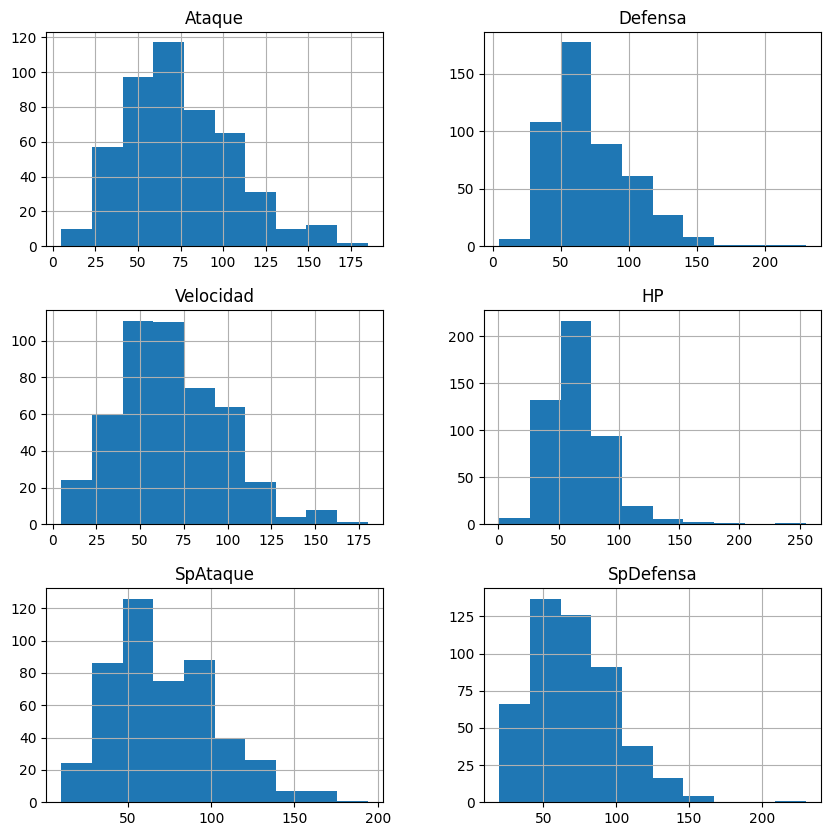

In [699]:
# Vista en histograma
df_pokemon.hist(figsize=(10,10))

La mayoría de las variables tiende a una distribución normal, HP tiene una posible prescencia de atípicos ya que se ve un leve sesgo hacia la derecha, aligual que con SPDefensa y Defensa.
En menor medida, Ataque, Velocidad y SpAtaque.

<Axes: >

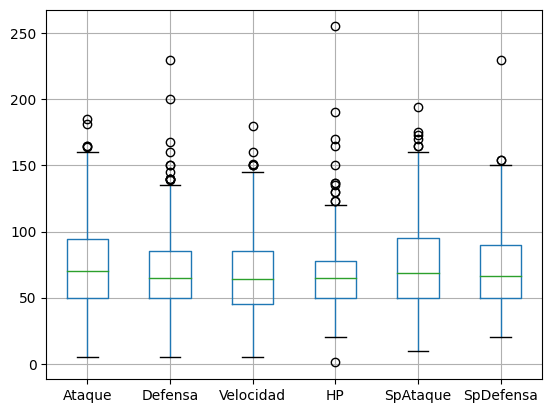

In [700]:
#Vista en boxplot
df_pokemon.boxplot()

Podemos ver que todas las variables tienen presencia de atípicos, las variables que mayor presencia de atípicos tienen son Defensa y HP, seguidas por SpAtaque; luego Ataque, Velocidad y SPDefensa en menor medida.

In [701]:

# Selecciona solo las columnas numéricas
numeric_columns_pok = df_pokemon.select_dtypes(include='number').columns

# Configura el layout del grid en subplots: 2 columnas por fila
rows = len(numeric_columns_pok) // 2 + len(numeric_columns_pok) % 2
fig = make_subplots(rows=rows, cols=2, subplot_titles=numeric_columns_pok)

# Itera sobre las columnas numéricas y crea un histograma por cada una
for i, col in enumerate(numeric_columns_pok):
    # Crear el histograma con Plotly y agrupar por el tipo de Pokémon
    fig_hist = px.histogram(df_pokemon, x=col, color='TipoPokemon', 
                            barmode='overlay')
    show_legend = i == 0 
    # Añadir el histograma a la posición correspondiente en el grid de subplots
    for trace in fig_hist['data']:
        trace.showlegend = show_legend
        fig.add_trace(trace, row=(i // 2) + 1, col=(i % 2) + 1)

# Configurar el layout del gráfico principal
fig.update_layout(
    title="Histograms of Numeric Features by Tipo Pokemon",
    width=1000,  # Ajustar el ancho total de la figura (más espacio para los histogramas)
    height=200 * rows,  # Ajustar la altura total, más alto para dar más espacio por fila
    hovermode="closest",  # Permite resaltar al pasar el cursor
    bargap=0.1,  # Menor espacio entre barras para que se vean más ajustadas
)

# Muestra el gráfico interactivo
fig.show()

Se puede observar que en el caso de Defensa, los valores hacia la derecha no se tratan realmente de atípicos ya que son valores comunes para el tipo de pokemón "Roca"; sin embargo, para las otras variables sí son atípicos.

## Vista de balanceado

<Axes: xlabel='TipoPokemon', ylabel='Count'>

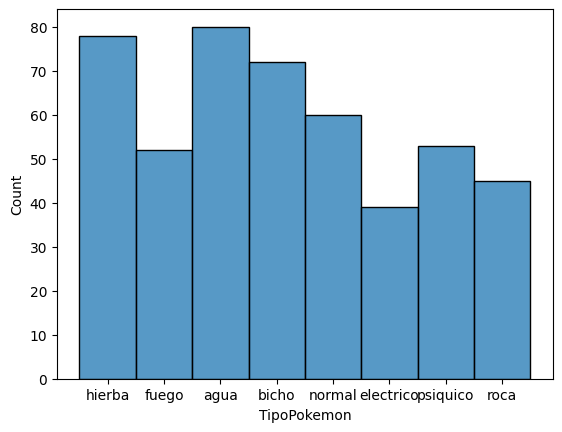

In [702]:
sns.histplot(df_pokemon['TipoPokemon'])

In [703]:
df_pokemon['TipoPokemon'].value_counts()

TipoPokemon
agua         80
hierba       78
bicho        72
normal       60
psiquico     53
fuego        52
roca         45
electrico    39
Name: count, dtype: int64

El dataset se encuentra medianamente balanceado. La clase eléctrico está en gran medida desbalanceada contra las demás, se puede observar que tiene una diferencia de 41 filas contra la que más filas tiene; luego le siguen roca (45), fuego (52) y psíquico(53),
Esto puede afectar a la hora de predecir si no se aplica alguna técnica de balanceo.

### Presencia de Null y Repetidos.

In [704]:
df_pokemon.isnull().any()

Nombre         False
Ataque         False
Defensa        False
Velocidad      False
HP             False
SpAtaque       False
SpDefensa      False
TipoPokemon    False
dtype: bool

No hay presencia de datos nulos.

In [705]:
df_pokemon.duplicated().any()

False

No hay filas duplicadas.

## Correlación.

<Axes: >

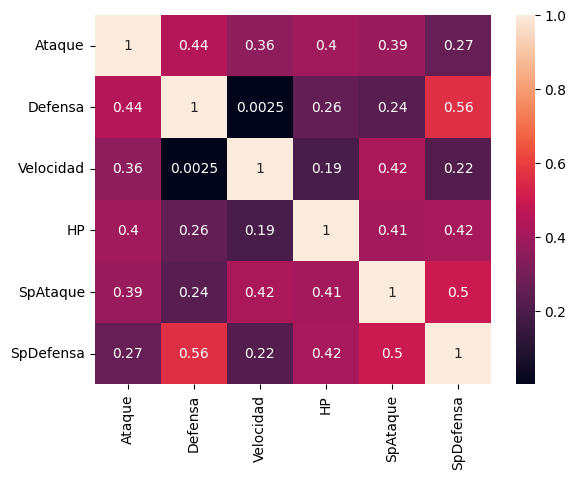

In [706]:
corr_pok = df_pokemon[numeric_columns_pok].corr()
sns.heatmap(corr_pok, annot= True)

Las variables presentan todas correlaciones positivas.
Las variables con mayor fuerza de correlación son:
- Defensa - SpDefensa : 0.56. Es una correlación moderada.
- SpAtaque - SpDefensa: 0.5. Correlación moderada.
- Defensa - Ataque : 0.44. Correlación moderada-baja.

En general, no hay correlaciones fuertes que indiquen una tendencia a una correlación fuertemente lineal.


# Modelos

## Preparación de datos

In [707]:
# Quita nombre ya que no es relevante
df_pokemon_sub = df_pokemon.drop(columns='Nombre')

In [708]:
X_pok = df_pokemon_sub.drop(columns='TipoPokemon') 
y_pok = df_pokemon_sub['TipoPokemon']

In [709]:
X_train_pok, X_test_pok, y_train_pok, y_test_pok = train_test_split(X_pok , y_pok, test_size=0.2, random_state=10)

In [710]:
X_train_pok_2, X_test_pok_2, y_train_pok_2, y_test_pok_2 = train_test_split(X_pok , y_pok, test_size=0.2, random_state=67)

# Punto 4: Árbol de Clasificación.

Realizar la estimación del atributo TipoPokemon utilizando árboles de decisión 
(Clasificación) analizando los parámetros máximo profundidad, número mínimo de 
observaciones, número mínimo de observaciones por separación y criterio de separación. 
Graficar un árbol obtenido en el proceso de entrenamiento y luego a aplicar una poda. 
Mostrar los resultados sobre ambos conjuntos de test (Precisión, Exhaustividad y 
Exactitud).

In [711]:
clas_tree = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier(max_depth=5,min_samples_split= 5, min_samples_leaf=5, splitter= 'best',random_state=13), )

In [712]:
clas_tree.fit(X_train_pok,y_train_pok)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=5,
                                        min_samples_split=5,
                                        random_state=13))])

In [713]:
y_train_pred_pok_clas = clas_tree.predict(X_train_pok)
y_pred_pok_clas = clas_tree.predict(X_test_pok)
y_2_pred_pok_clas = clas_tree.predict(X_test_pok_2)

In [714]:
features_pok = list(X_train_pok.columns)

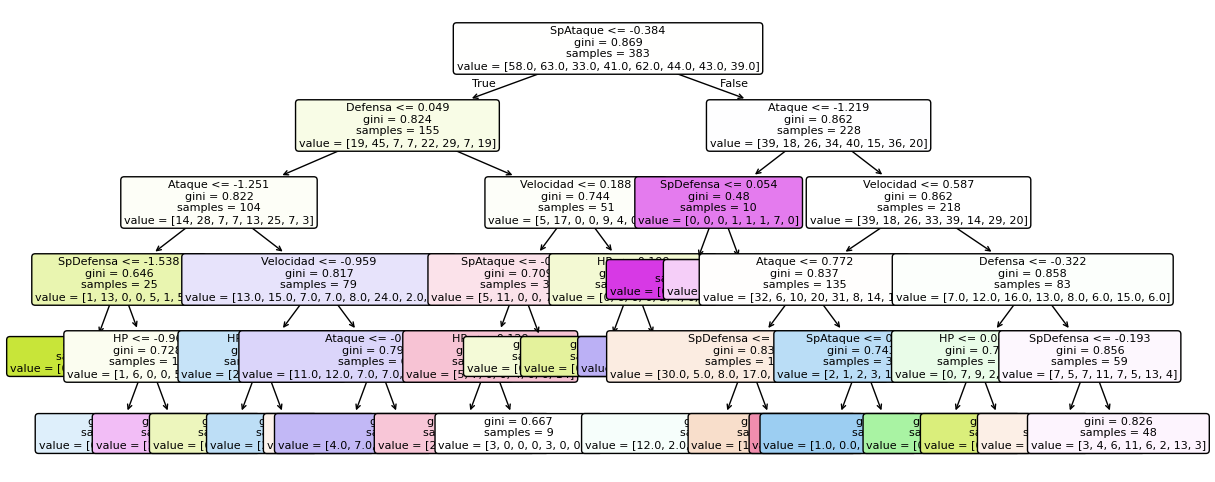

In [715]:
plot_tree(clas_tree, features_pok)

En este árbol, los valores de Gini disminuyen a medida que el árbol se profundiza, lo que significa que los nodos se vuelven progresivamente más puros. En cada división, el objetivo es minimizar la impureza de Gini para mejorar la clasificación de las muestras. Sin embargo podemos ver que no llega a un valor bajo de Ginni, lo que sugiere que las hojas del árbol contienen clases mezcladas en gran cantidad. Por ejemplo, la hoja de la derecha tiene todas las clases en mayor o menor medida cada una, pero en valores muy cercanos; lo cual se traduce en un gini 0.826

## Variando Parámetros Manualmente

### 2

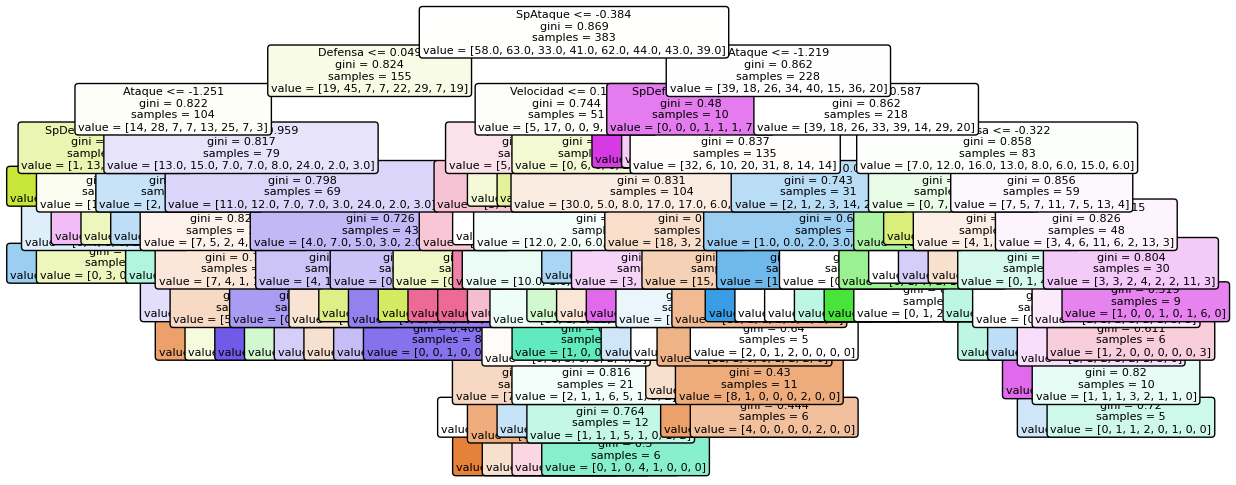

In [716]:
clas_tree_2 = make_pipeline(StandardScaler(),tree.DecisionTreeClassifier(max_depth=30,min_samples_split= 5, min_samples_leaf=5, splitter= 'best',random_state=14), )
clas_tree_2.fit(X_train_pok,y_train_pok)
y_train_pred_pok_clas_2 = clas_tree_2.predict(X_train_pok)
y_pred_pok_clas_2 = clas_tree_2.predict(X_test_pok)
y_2_pred_pok_clas_2 = clas_tree.predict(X_test_pok_2)
plot_tree(clas_tree_2, features_pok)

In [717]:
min(clas_tree_2[1].tree_.impurity)

0.0

Si le damos mayor profundidas al árbol, podemos ver que llega a niveles de pureza de ginni más bajos. Llegando así a una impureza de gini de 0.0; es decir, un nodo que contenga todos sus datos de una sola clase.

### 3

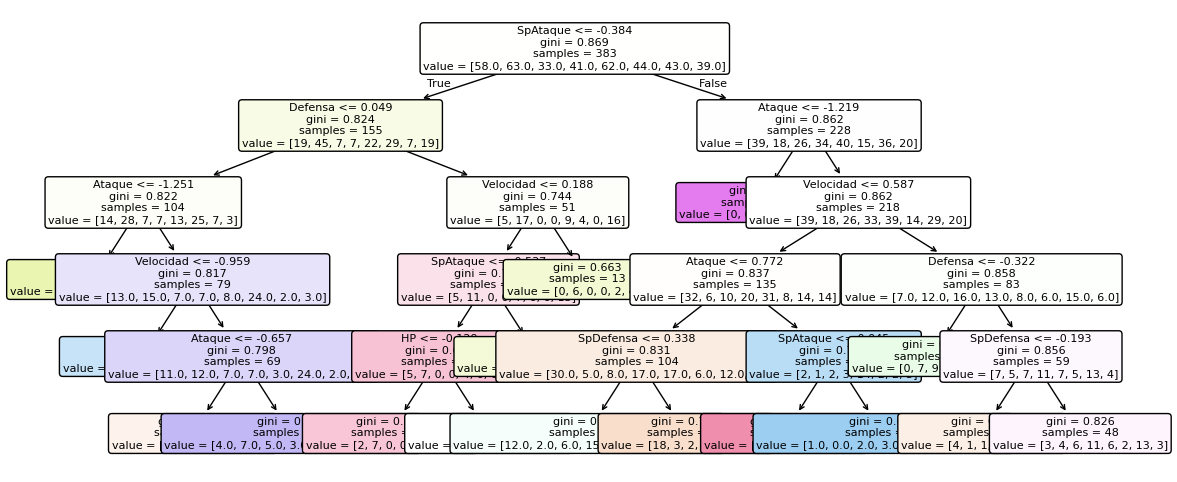

In [718]:
clas_tree_3 = make_pipeline(StandardScaler(),tree.DecisionTreeClassifier(max_depth=5,min_samples_split= 30, min_samples_leaf=5, splitter= 'best',random_state=15), )
clas_tree_3.fit(X_train_pok,y_train_pok)
y_train_pred_pok_clas_3 = clas_tree_3.predict(X_train_pok)
y_pred_pok_clas_3 = clas_tree_3.predict(X_test_pok)
y_2_pred_pok_clas_3 = clas_tree.predict(X_test_pok_2)
plot_tree(clas_tree_3, features_pok)

### 4

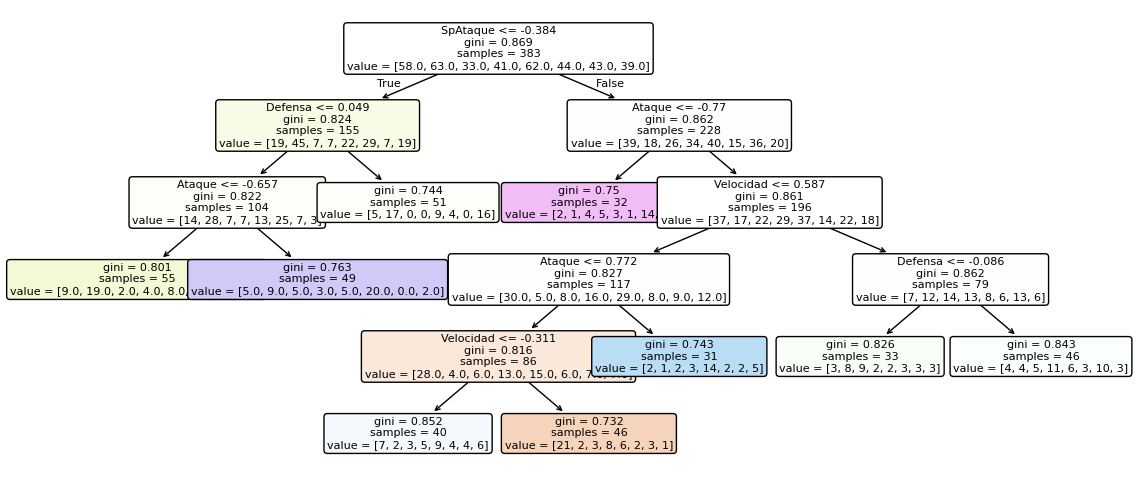

In [719]:
clas_tree_4 = make_pipeline(StandardScaler(),tree.DecisionTreeClassifier(max_depth=5,min_samples_split= 5, min_samples_leaf=30, splitter= 'best',random_state=16), )
clas_tree_4.fit(X_train_pok,y_train_pok)
y_train_pred_pok_clas_4 = clas_tree_4.predict(X_train_pok)
y_pred_pok_clas_4 = clas_tree_4.predict(X_test_pok)
y_2_pred_pok_clas_4 = clas_tree.predict(X_test_pok_2)
plot_tree(clas_tree_4, features_pok)

## Métricas

#### Matrices de confusión

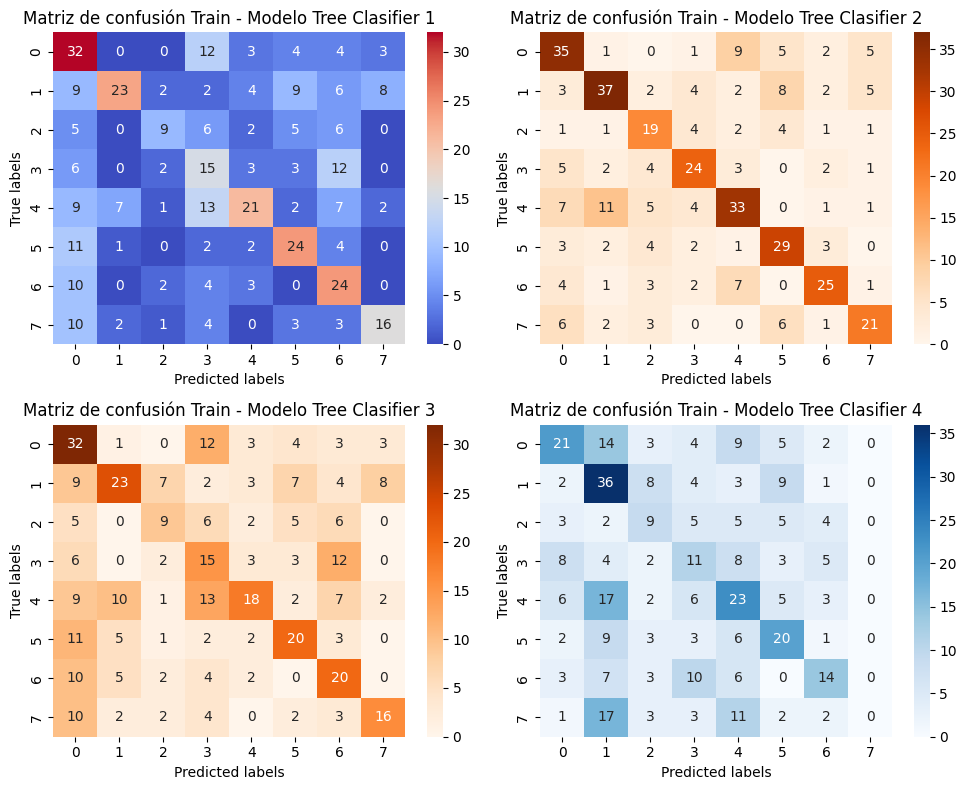

In [720]:
plot_multiple_conf_matrices(
    [y_train_pok,y_train_pok,y_train_pok,y_train_pok],
    [y_train_pred_pok_clas,y_train_pred_pok_clas_2,y_train_pred_pok_clas_3,y_train_pred_pok_clas_4],
    ['Matriz de confusión Train - Modelo Tree Clasifier 1','Matriz de confusión Train - Modelo Tree Clasifier 2','Matriz de confusión Train - Modelo Tree Clasifier 3','Matriz de confusión Train - Modelo Tree Clasifier 4']
      )

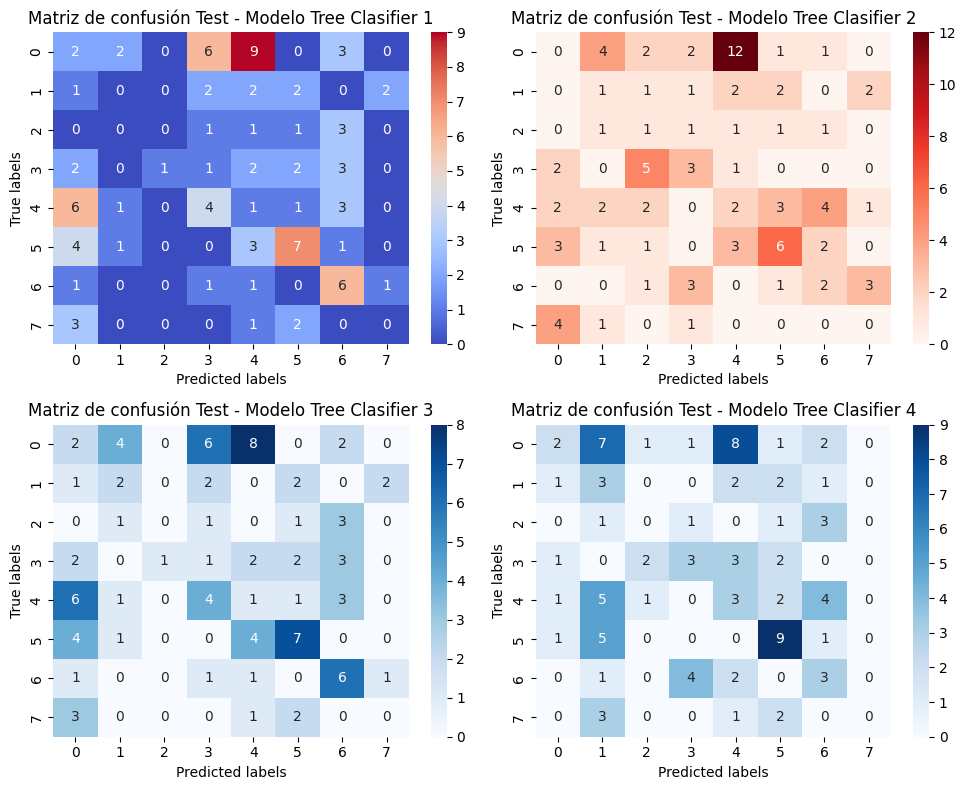

In [721]:
plot_multiple_conf_matrices(
    [y_test_pok,y_test_pok,y_test_pok,y_test_pok],
    [y_pred_pok_clas,y_pred_pok_clas_2,y_pred_pok_clas_3,y_pred_pok_clas_4],
    ['Matriz de confusión Test - Modelo Tree Clasifier 1','Matriz de confusión Test - Modelo Tree Clasifier 2','Matriz de confusión Test - Modelo Tree Clasifier 3','Matriz de confusión Test - Modelo Tree Clasifier 4']
      )

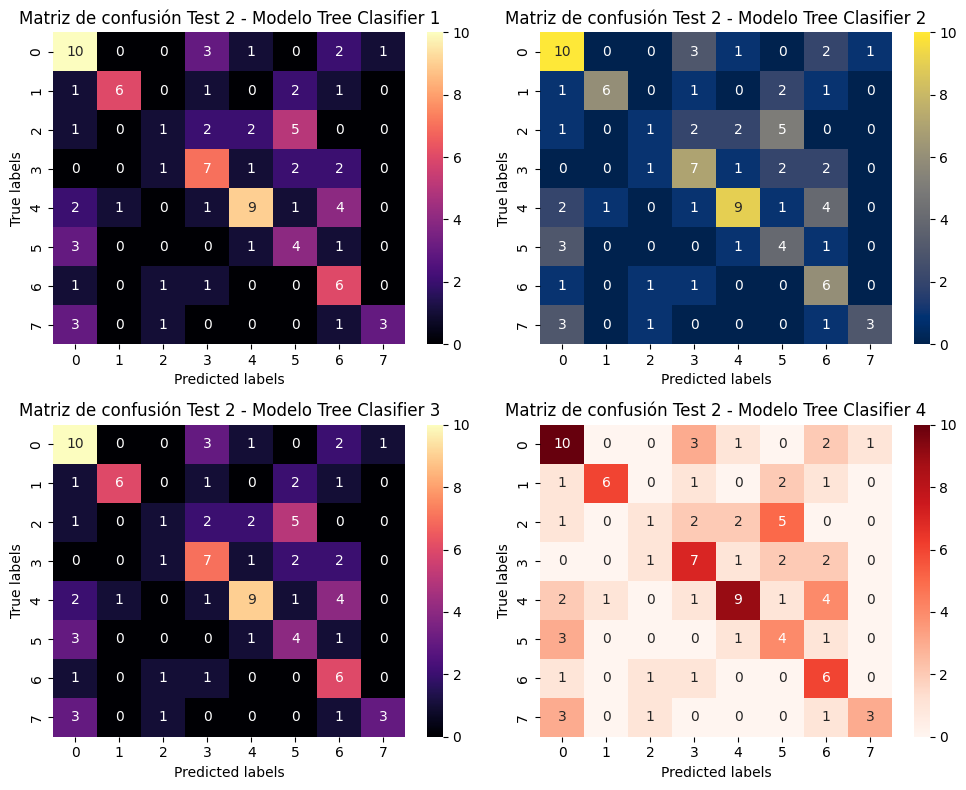

In [722]:
plot_multiple_conf_matrices(
    [y_test_pok_2,y_test_pok_2,y_test_pok_2,y_test_pok_2],
    [y_2_pred_pok_clas,y_2_pred_pok_clas_2,y_2_pred_pok_clas_3,y_2_pred_pok_clas_4],
    ['Matriz de confusión Test 2 - Modelo Tree Clasifier 1','Matriz de confusión Test 2 - Modelo Tree Clasifier 2','Matriz de confusión Test 2 - Modelo Tree Clasifier 3','Matriz de confusión Test 2 - Modelo Tree Clasifier 4']
      )

### Otras Metricas

In [723]:
dic_modelo_tree ={
    'Clasification_tree' : [[5,5,5,'Best'],(y_train_pok,y_train_pred_pok_clas),(y_test_pok,y_pred_pok_clas),(y_test_pok,y_2_pred_pok_clas)],
    'Clasification_tree_2': [[30,5,5,'Best'],(y_train_pok,y_train_pred_pok_clas_2), (y_test_pok,y_pred_pok_clas_2),(y_test_pok,y_2_pred_pok_clas_2)],
    'Clasification_tree_3': [[5,30,5,'Best'],(y_train_pok,y_train_pred_pok_clas_3),(y_test_pok,y_pred_pok_clas_3),(y_test_pok,y_2_pred_pok_clas_3)],
    'Clasification_tree_4': [[5,5,30,'Best'],(y_train_pok,y_train_pred_pok_clas_4),(y_test_pok,y_pred_pok_clas_4),(y_test_pok,y_2_pred_pok_clas_4)]
}
metricas_modelos_tree = pd_metricas_clasifier(
    dic_modelo_tree
)

In [724]:
metricas_modelos_tree

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
0,Clasification_tree,5,5,5,Best,0.482229,0.428198,0.428198,0.430901,0.150768,0.177083,0.177083,0.158803,0.129639,0.114583,0.114583,0.120248
0,Clasification_tree_2,30,5,5,Best,0.587926,0.582245,0.582245,0.582994,0.153568,0.156250,0.156250,0.153215,0.129639,0.114583,0.114583,0.120248
0,Clasification_tree_3,5,30,5,Best,0.431542,0.399478,0.399478,0.400226,0.176941,0.197917,0.197917,0.183671,0.129639,0.114583,0.114583,0.120248
0,Clasification_tree_4,5,5,30,Best,0.322546,0.349869,0.349869,0.329120,0.253418,0.239583,0.239583,0.223985,0.129639,0.114583,0.114583,0.120248


## Optimización de Hiperparámetros

In [725]:
scaler = StandardScaler()
X_train_pok_escaled =  scaler.fit_transform(X_train_pok)
X_test_pok_escaled = scaler.transform(X_test_pok)
X_test_2_pok_escaled = scaler.transform(X_test_pok_2)

In [726]:
param_grid_pok = {
    'max_depth': [5, 6, 9, 10, 11,30],
    'min_samples_split':[5,10,15,20,25,30],
    'min_samples_leaf': [3,5,10,15,20,30],
    'splitter': ['best', 'random'],
    'random_state': [18]
}
grid_search_pok = GridSearchCV(tree.DecisionTreeClassifier(),
                                   param_grid_pok )

grid_search_pok.fit(X_train_pok_escaled, y_train_pok)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [5, 6, 9, 10, 11, 30],
                         'min_samples_leaf': [3, 5, 10, 15, 20, 30],
                         'min_samples_split': [5, 10, 15, 20, 25, 30],
                         'random_state': [18], 'splitter': ['best', 'random']})

In [727]:
#veo mejores parámetros encontrados
grid_search_pok.best_params_

{'max_depth': 5,
 'min_samples_leaf': 20,
 'min_samples_split': 5,
 'random_state': 18,
 'splitter': 'best'}

In [728]:
best_tree_pok = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier(min_samples_split= 5, min_samples_leaf=20, max_depth=5, splitter='best', random_state= 7))

In [729]:
best_tree_pok.fit(X_train_pok,y_train_pok)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=20,
                                        min_samples_split=5, random_state=7))])

In [730]:
## Hago predicciones test
best_train_prediction_pok = best_tree_pok.predict(X_train_pok)
best_prediction_pok = best_tree_pok.predict(X_test_pok)
best_2_prediction_pok = best_tree_pok.predict(X_test_pok_2)

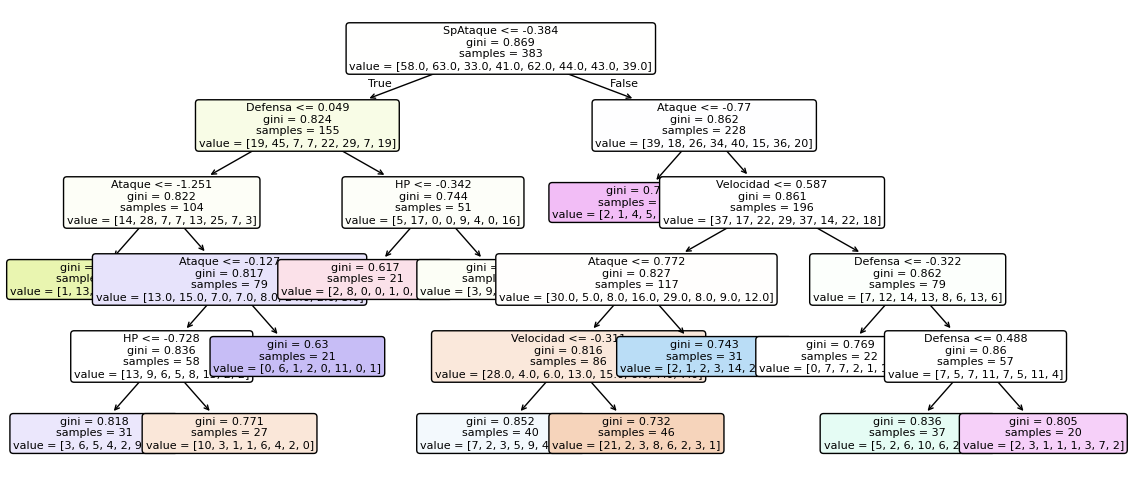

In [731]:
plot_tree(best_tree_pok, features_pok)

In [732]:
dict_best = {
    'Best Clasification_tree' : [[5,20,5,'Best'], (y_train_pok, best_train_prediction_pok), (y_test_pok, best_prediction_pok), (y_test_pok, best_2_prediction_pok)]
}
metricas_modelos_tree = pd.concat([metricas_modelos_tree, pd_metricas_clasifier(dict_best)])

In [733]:
metricas_modelos_tree

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
0,Clasification_tree,5,5,5,Best,0.482229,0.428198,0.428198,0.430901,0.150768,0.177083,0.177083,0.158803,0.129639,0.114583,0.114583,0.120248
0,Clasification_tree_2,30,5,5,Best,0.587926,0.582245,0.582245,0.582994,0.153568,0.156250,0.156250,0.153215,0.129639,0.114583,0.114583,0.120248
0,Clasification_tree_3,5,30,5,Best,0.431542,0.399478,0.399478,0.400226,0.176941,0.197917,0.197917,0.183671,0.129639,0.114583,0.114583,0.120248
0,Clasification_tree_4,5,5,30,Best,0.322546,0.349869,0.349869,0.329120,0.253418,0.239583,0.239583,0.223985,0.129639,0.114583,0.114583,0.120248
0,Best Clasification_tree,5,20,5,Best,0.345647,0.375979,0.375979,0.354701,0.236248,0.260417,0.260417,0.244096,0.167910,0.156250,0.156250,0.160530


Podemos ver como se generan grandes impactos en el rendimiento de los modelos:
- Sobreajuste en el Conjunto de Entrenamiento (Test 1):
    - Classification_tree_2, con una profundidad máxima de 30, muestra métricas más altas en el conjunto de entrenamiento (Test 1), lo cual indica que el modelo está capturando más patrones de los datos. Esto sugiere que el modelo podría estar sobreajustado a los datos de entrenamiento, logrando una alta precisión y recall en este conjunto, pero disminuyendo significativamente en los otros conjuntos de pruebas (Test 2 y Test 3).
    
    Los modelos con menor profundidad (como Best Classification_tree, con una profundidad de 5 y Min_obs de 20) presentan un rendimiento moderado en Test 1, lo que sugiere que están menos ajustados a los datos de entrenamiento y, en consecuencia, podrían generalizar mejor en nuevos datos.

- Evaluación de la Generalización en Test 2 y Test 3

    - En el análisis de los modelos en los conjuntos de prueba Test 2 y Test 3, se observa que las métricas tienden a ser consistentemente más bajas que en el conjunto de entrenamiento (Test 1). Esto refuerza la idea de que algunos modelos están sobreajustados, como el Classification_tree_2, que pierde efectividad en estos conjuntos de prueba.
    
    Por otro lado, Best Classification_tree muestra un mejor equilibrio en Test 2, con un F1-score más alto que en Test 1, sugiriendo que el modelo no está sobreajustado a los datos de entrenamiento y es capaz de generalizar mejor a conjuntos externos.

Se puede rescatar como conclusión que es crucial evitar una profundidad excesiva y mantener un mínimo adecuado de observaciones en cada nodo para controlar el ajuste. Best Classification_tree parece ofrecer el mejor compromiso entre ajuste y generalización, lo cual es fundamental para asegurar que el modelo sea efectivo no solo en los datos de entrenamiento, sino también en datos no vistos.

## Conclusiones Decision Tree Clasifier.

Los hiperparámetros en un árbol de decisión tienen una gran influencia en su comportamiento y en los resultados de la clasificación:
- max_depth:
    - Profundidad alta: Un árbol con una profundidad alta puede aprender relaciones complejas en los datos, lo que suele reducir el error en el conjunto de entrenamiento (underfitting), pero aumenta el riesgo de sobreajuste (overfitting).
    - Profundidad baja: Con una profundidad limitada, el árbol es más simple y generaliza mejor en conjuntos de datos pequeños o con ruido, reduciendo el riesgo de sobreajuste, pero puede no capturar patrones complejos (underfitting).
- min_samples_split:
    - Valor bajo: Permite más divisiones y da como resultado un árbol más profundo. Esto puede llevar a sobreajuste si el valor es demasiado bajo. Aunque por esto también se ajusta la profundidad.
    - Valor alto: Limita la cantidad de divisiones, produciendo un árbol más compacto y menos complejo. Puede ayudar a evitar el sobreajuste en conjuntos de datos pequeños o con ruido, pero corre el riesgo de que el modelo no capture patrones importantes (underfitting).
- min_samples_leaf:
    - Valor bajo: Permite nodos con pocas muestras, lo que puede llevar a un sobreajuste.
    - Valor alto: Obliga a las hojas a contener más muestras, reduciendo el número de nodos en el árbol. Esto puede hacer que el modelo sea más robusto, especialmente en conjuntos de datos ruidosos, ya que reduce el impacto de outliers.
- max_features:
    - Valor bajo: Reduce el número de características candidatas para cada división, esto puede llevar a underfitting.
    - Valor alto: Permite considerar más características en cada división, lo que suele aumentar el rendimiento en el conjunto de entrenamiento, pero también aumenta el riesgo de sobreajuste en el árbol.

# Punto 5: Bayes Ingenuo

Realizar la estimación del atributo TipoPokemon utilizando Bayes Ingenuo. Aquí deberá
considerar un criterio de división de los atributos para discretizarlos. Mostrar los resultados
sobre ambos conjuntos de test (Precisión, Exhaustividad y Exactitud).

In [734]:
def discretizacion(X):
    '''
    Toma un df X y devuelve dicho df discretizado para Bayes Ingenuo
    '''
    label_encoder = LabelEncoder()
    X_discreto = X.copy()
    for c in X.columns:
        X_discreto[c] = label_encoder.fit_transform(X_discreto[c])

    return X_discreto

In [735]:
X_train_pok_discreto = discretizacion(X_train_pok)
X_test_pok_discreto = discretizacion(X_test_pok)
X_test_2_pok_discreto = discretizacion(X_test_pok_2)

## GaussianNB

In [736]:
model_bayes_nb = make_pipeline(MinMaxScaler(),GaussianNB())
model_bayes_nb.fit(X_train_pok_discreto, y_train_pok)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('gaussiannb', GaussianNB())])

In [737]:
y_train_pok_pred_bayes = model_bayes_nb.predict(X_train_pok_discreto)
y_test_pok_pred_bayes = model_bayes_nb.predict(X_test_pok_discreto)
y_test_2_pok_pred_bayes = model_bayes_nb.predict(X_test_2_pok_discreto)

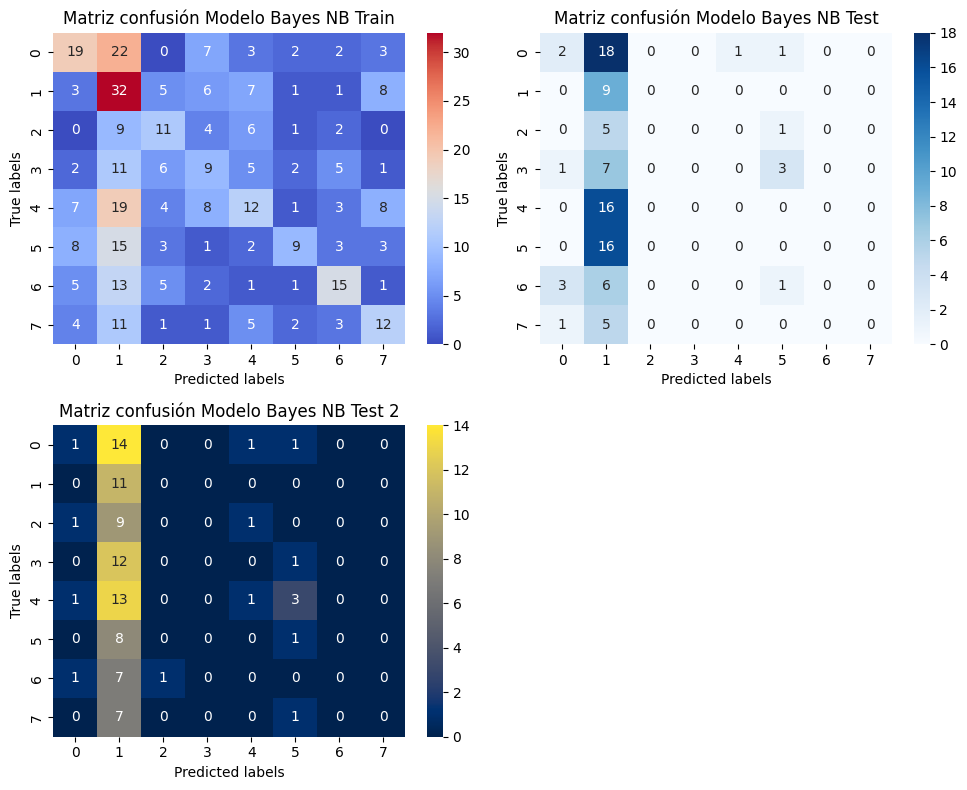

In [738]:
plot_multiple_conf_matrices(
    [y_train_pok,y_test_pok,y_test_pok_2],
    [y_train_pok_pred_bayes,y_test_pok_pred_bayes,y_test_2_pok_pred_bayes],
    ['Matriz confusión Modelo Bayes NB Train', 'Matriz confusión Modelo Bayes NB Test', 'Matriz confusión Modelo Bayes NB Test 2'])

Observaciones:
- Clase 0: Agua.
- Clase 1: Bicho.
- Clase 2: Eléctrico.
- Clase 3: Fuego.
- Clase 4: Hierba.
- Clase 5: Normal.
- Clase 6: Psíquico.
- Clase 7: Roca.

In [739]:
y_train_pok.value_counts()

TipoPokemon
bicho        63
hierba       62
agua         58
normal       44
psiquico     43
fuego        41
roca         39
electrico    33
Name: count, dtype: int64

Se observa que no tiene una buena performance en cuanto a la clasificación correcta de las clases:
- Sobre conjunto Train (matriz superior izquierda):  Podemos ver como de las 58 etiquetas de 'Agua' (clase 0) solo predice bien 22 confusión con predecirlas como 'Bicho' (clase 1). Esta última clase es la que parece tener mejores valores ded verdaderos positivos, teniendo 32 casos bien clasificados de los (63). Sin embargo sigue siendo bajo (50% de esta clase solo fue bien clasificada).
- Sobre el conjunto Test 1 (matriz superior derecha): tiene una buena performance solo para la clase 'Bicho' (clase 1) la cual clasifica a la perfección. Sin embargo, muy mala performance para el resto.
- Sobre el conjunto Test 2 (matriz inferior izquierda): Se repite el caso del conjunto Test 1.

Las performance de ambos conjuntos test tienen sentidos ya que 'traslada' lo aprendido en el train. El modelo no logra un rendimiento óptimo para clasificar estas clases de manera consistente. La confusión entre clases  "Agua", "Bicho", "Fuego" y "Hierba" lo hace evidente.

In [740]:
## Métricas
dict_bayes = {
    'Modelo Bayes NB': [[None, None, None, None], (y_train_pok,y_train_pok_pred_bayes), (y_test_pok,y_test_pok_pred_bayes), (y_test_pok_2, y_test_2_pok_pred_bayes)]
}
metricas_bayes = pd_metricas_clasifier(dict_bayes)

In [741]:
metricas_bayes

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
0,Modelo Bayes NB,None,None,None,None,0.337525,0.310705,0.310705,0.307412,0.075766,0.114583,0.114583,0.050153,0.135724,0.145833,0.145833,0.073841


Se puede observar que este modelo está tiene rendimientos muy disparejos para el test 1(sobre el conjunto de train) y test 2 y test 3. Siendo mucho más bajos los rendimientos en comparación con los modelos implementados anteriormente. Esto se debe a que no logra diferenciar bien una clase de otra y tiende a  clase mayoritaria.

## MultinomialNB

In [742]:
model_bayes_mn = make_pipeline(MinMaxScaler(), MultinomialNB())
model_bayes_mn.fit(X_train_pok_discreto, y_train_pok)


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('multinomialnb', MultinomialNB())])

In [743]:
y_train_pok_pred_bayes_MN = model_bayes_mn.predict(X_train_pok_discreto)
y_test_pok_pred_bayes_MN = model_bayes_mn.predict(X_test_pok_discreto)
y_test_2_pok_pred_bayes_MN = model_bayes_mn.predict(X_test_2_pok_discreto)

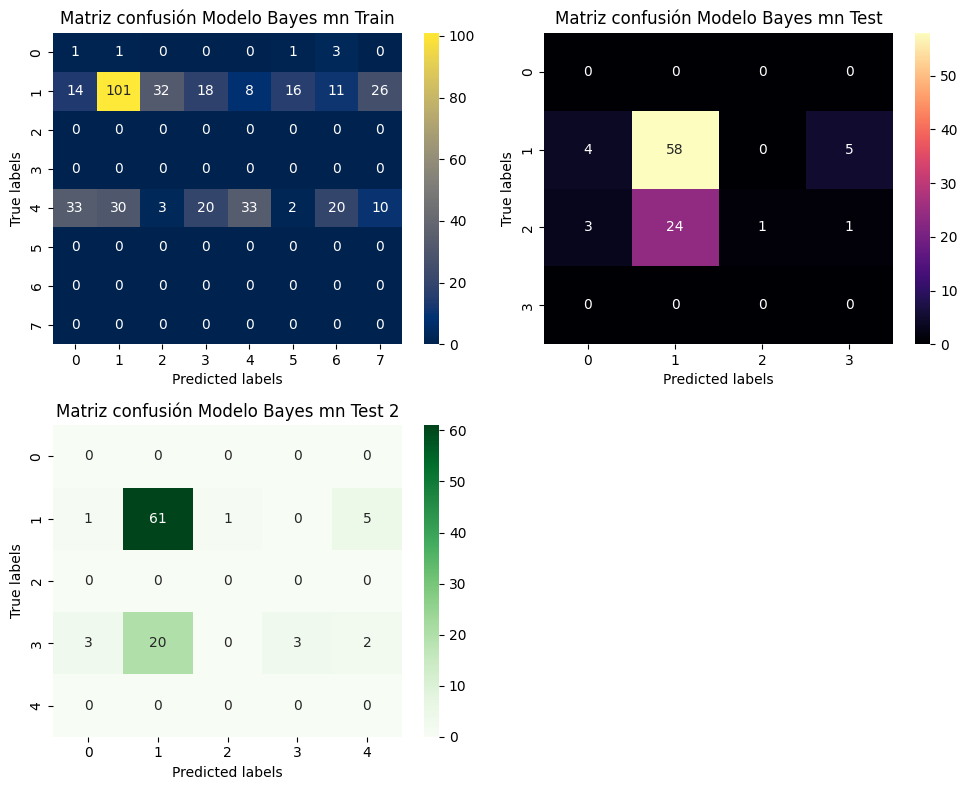

In [744]:
plot_multiple_conf_matrices(
    [y_train_pok_pred_bayes_MN,y_test_pok_pred_bayes_MN,y_test_2_pok_pred_bayes_MN],
    [y_train_pok_pred_bayes,y_test_pok_pred_bayes,y_test_2_pok_pred_bayes],
    ['Matriz confusión Modelo Bayes mn Train', 'Matriz confusión Modelo Bayes mn Test', 'Matriz confusión Modelo Bayes mn Test 2'])

In [745]:
## Métricas
dict_bayes = {
    'Modelo Bayes MN': [[None, None, None, None], (y_train_pok,y_train_pok_pred_bayes_MN), (y_test_pok,y_test_pok_pred_bayes_MN), (y_test_pok_2, y_test_2_pok_pred_bayes_MN)]
}
metricas_bayes =pd.concat([metricas_bayes,pd_metricas_clasifier(dict_bayes)])

In [746]:
metricas_bayes

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
0,Modelo Bayes NB,None,None,None,None,0.337525,0.310705,0.310705,0.307412,0.075766,0.114583,0.114583,0.050153,0.135724,0.145833,0.145833,0.073841
0,Modelo Bayes MN,None,None,None,None,0.097009,0.219321,0.219321,0.111810,0.050025,0.145833,0.145833,0.069122,0.070422,0.187500,0.187500,0.094226


Este segundo modelo tiene la misma tendencia que el anterior a clasificar a la mayoria de clases como 'Bicho'. Algo distinto -y esperable- que hace este modelo es suprimir clases en su entrenamiento (anula clases 5,6 y 7), como en los test (3,4,5,6 y 7 en el test 1 y 4,5,6 y 7 en el test 2).

## BernoulliNB

In [747]:
model_bayes_BN = make_pipeline(StandardScaler(), BernoulliNB())
model_bayes_BN.fit(X_train_pok_discreto,y_train_pok)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('bernoullinb', BernoulliNB())])

In [748]:
y_train_pok_pred_bayes_BN = model_bayes_BN.predict(X_train_pok_discreto)
y_test_pok_pred_bayes_BN = model_bayes_BN.predict(X_test_pok_discreto)
y_test_2_pok_pred_bayes_BN = model_bayes_BN.predict(X_test_2_pok_discreto)

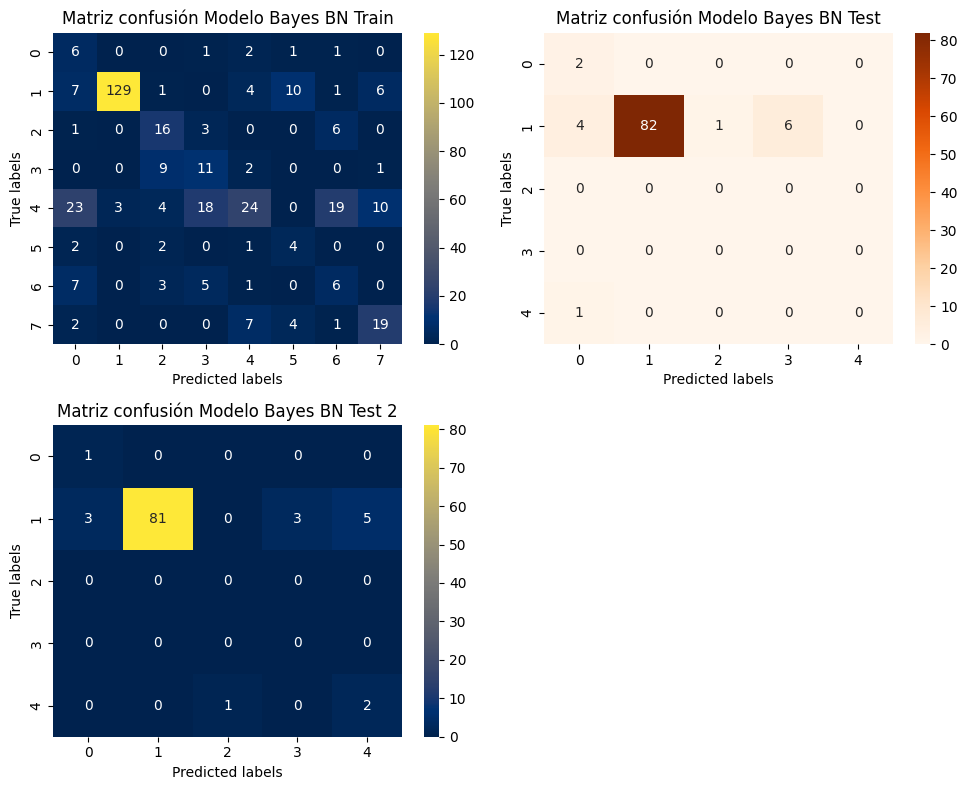

In [749]:
plot_multiple_conf_matrices(
    [y_train_pok_pred_bayes_BN,y_test_pok_pred_bayes_BN,y_test_2_pok_pred_bayes_BN],
    [y_train_pok_pred_bayes,y_test_pok_pred_bayes,y_test_2_pok_pred_bayes],
    ['Matriz confusión Modelo Bayes BN Train', 'Matriz confusión Modelo Bayes BN Test', 'Matriz confusión Modelo Bayes BN Test 2'])

Se puede observar de manera mucho más notoria como el modelo directamente tiende a clasificar la clase mayoritaria (Bicho). Teniendo un score similar a un modelo que solamente devuelva la clase 'Bicho', sin necesidad de implementar Bayes. Sin mencionar que anula aún más clases que el modelo MultinomialNB visto anteriormente.

In [750]:
## Métricas
dict_bayes = {
    'Modelo Bayes BN': [[None, None, None, None], (y_train_pok,y_train_pok_pred_bayes_BN), (y_test_pok,y_test_pok_pred_bayes_BN), (y_test_pok_2, y_test_2_pok_pred_bayes_BN)]
}
metricas_bayes =pd.concat([metricas_bayes,pd_metricas_clasifier(dict_bayes)])

In [751]:
metricas_bayes

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
0,Modelo Bayes NB,None,None,None,None,0.337525,0.310705,0.310705,0.307412,0.075766,0.114583,0.114583,0.050153,0.135724,0.145833,0.145833,0.073841
0,Modelo Bayes MN,None,None,None,None,0.097009,0.219321,0.219321,0.111810,0.050025,0.145833,0.145833,0.069122,0.070422,0.187500,0.187500,0.094226
0,Modelo Bayes BN,None,None,None,None,0.262499,0.240209,0.240209,0.205752,0.113239,0.104167,0.104167,0.035484,0.044950,0.125000,0.125000,0.040099


# Punto 6: K-NN

Realizar la estimación del atributo TipoPokemon utilizando k-NN analizando los
parámetros cantidad de vecinos, métrica y valor de p. Mostrar los resultados sobre ambos
conjuntos de test (Precisión, Exhaustividad y Exactitud).

In [752]:
from sklearn.neighbors import KNeighborsClassifier

In [753]:
knn_model = make_pipeline(StandardScaler(),KNeighborsClassifier())
knn_model.fit(X_train_pok,y_train_pok)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [754]:
y_train_pok_predict_knn = knn_model.predict(X_train_pok)
y_test_2_pok_predict_knn = knn_model.predict(X_test_pok)
y_test_2_pok_predict_knn = knn_model.predict(X_test_pok_2)

In [755]:
pd.isna(y_train_pok_predict_knn).any(),pd.isna(y_test_2_pok_predict_knn).any(),pd.isna(y_test_2_pok_predict_knn).any()

(False, False, False)

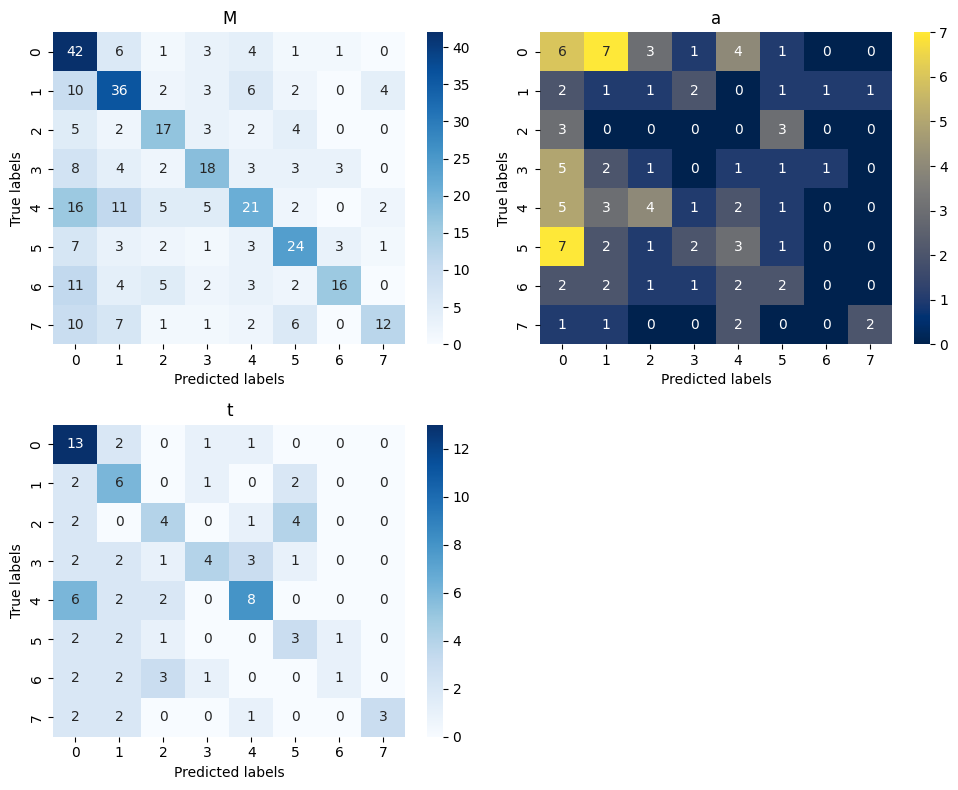

In [756]:
plot_multiple_conf_matrices(
    [y_train_pok,y_test_pok,y_test_pok_2],
    [y_train_pok_predict_knn,y_test_2_pok_predict_knn,y_test_2_pok_predict_knn],
    'Matrices Confusión Modelo KNN'
)

In [757]:
## Métricas
dict_knn = {
    'Modelo knn K = 5': [[None, None, None, None], (y_train_pok,y_train_pok_predict_knn), (y_test_pok,y_test_2_pok_predict_knn), (y_test_pok_2, y_test_2_pok_predict_knn)]
}
metricas_knn =pd_metricas_clasifier(dict_knn)

In [758]:
metricas_knn

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
0,Modelo knn K = 5,None,None,None,None,0.517183,0.48564,0.48564,0.479759,0.131706,0.125,0.125,0.121652,0.496979,0.4375,0.4375,0.425023


El modelo muestra un rendimiento moderado en el conjunto de entrenamiento, con métricas que no son particularmente altas, lo que sugiere que podría estar subajustado, incluso en los datos de entrenamiento.

En Test 2, el rendimiento es muy bajo en todas las métricas, lo cual indica que el modelo no generaliza bien fuera del conjunto de entrenamiento, reforzando la hipótesis vista en el conjunto de train (Test 1). El modelo muestra un rendimiento intermedio en Test 3, con métricas más altas que en Test 2 pero aún por debajo de las del entrenamiento; esto se debe ya que posiblemente datos que estén en Test 3 también están en Train, recordando que se hicieron dos separaciones del conjunto.

La baja precisión y recall en los conjuntos de prueba indican que el modelo K-NN con 𝐾 = 5 no se adapta bien a los datos de prueba, mostrando dificultades para generalizar correctamente. Los resultados sugieren que el modelo necesita ajustes adicionales para mejorar su rendimiento y consistencia en nuevos datos.

In [759]:
metricas_bayes

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
0,Modelo Bayes NB,None,None,None,None,0.337525,0.310705,0.310705,0.307412,0.075766,0.114583,0.114583,0.050153,0.135724,0.145833,0.145833,0.073841
0,Modelo Bayes MN,None,None,None,None,0.097009,0.219321,0.219321,0.111810,0.050025,0.145833,0.145833,0.069122,0.070422,0.187500,0.187500,0.094226
0,Modelo Bayes BN,None,None,None,None,0.262499,0.240209,0.240209,0.205752,0.113239,0.104167,0.104167,0.035484,0.044950,0.125000,0.125000,0.040099


Podemos observar una mejor performance en comparación con Bayes Ingenuo mejora en cuanto a Accuracy en un 0.1 / 0.2 para train (test 1), sin embargo los valores de dicha métrica para los otros sets de datos son similares.
A diferencia de Bayes, algo a destacar, no elimina clases en ninguna predicción ni entrenamiento; clasificando bien al menos 1 dato de cada clase rn Test 2 y entrenamiento.

### Optimización K-NN

In [760]:
np.sqrt(len(X_train_pok))

19.570385790780925

In [761]:
KNeighborsClassifier()

KNeighborsClassifier()

In [762]:
from sklearn.model_selection import StratifiedKFold

In [763]:
param_grid_pok_knn = {
    'n_neighbors' : [1, 3 , 5 , 10 , 15, round(np.sqrt(len(X_train_pok))), 25, 30, 40, 50, 60,70]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_model_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_pok_knn,
    scoring='precision_macro',
    cv=skf
)
best_model_knn.fit(X_train_pok_escaled, y_train_pok)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 10, 15, 20, 25, 30, 40, 50,
                                         60, 70]},
             scoring='precision_macro')

In [764]:
y_train_pok_predict_knn_best = best_model_knn.predict(X_train_pok_escaled)
y_test_2_pok_predict_knn_best = best_model_knn.predict(X_test_pok_escaled)
y_test_2_pok_predict_knn_best = best_model_knn.predict(X_test_2_pok_escaled)

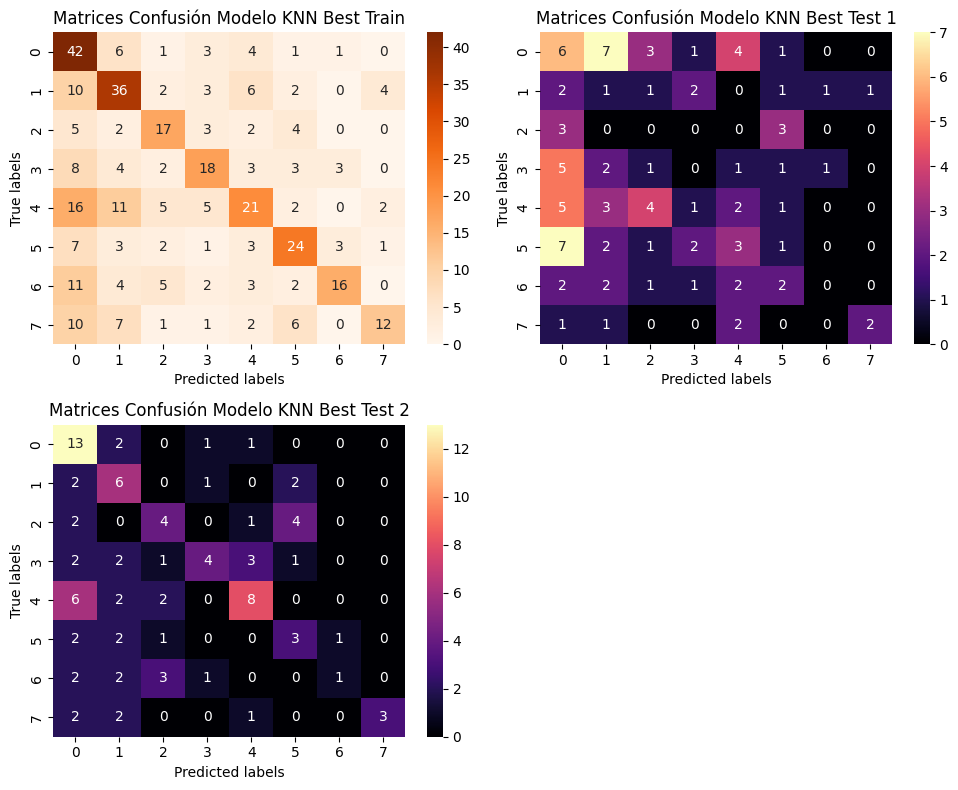

In [765]:
plot_multiple_conf_matrices(
    [y_train_pok,y_test_pok,y_test_pok_2],
    [y_train_pok_predict_knn_best,y_test_2_pok_predict_knn_best,y_test_2_pok_predict_knn_best],
    ['Matrices Confusión Modelo KNN Best Train', 'Matrices Confusión Modelo KNN Best Test 1', 'Matrices Confusión Modelo KNN Best Test 2']
)

In [766]:
## Métricas
dict_knn = {
    f"Modelo Best knn K = {best_model_knn.best_params_['n_neighbors']}": [[None, None, None, None], (y_train_pok,y_train_pok_predict_knn_best), (y_test_pok,y_test_2_pok_predict_knn_best), (y_test_pok_2, y_test_2_pok_predict_knn_best)]
}
metricas_knn =pd.concat([metricas_knn,pd_metricas_clasifier(dict_knn)])

In [767]:
metricas_knn

,Nombre_Modelo,Max_profundidad,Min_obs,Min_Obs_x_Sep,Criterio_Sep,Precision Test 1,Recall Test 1,Accuracy Test 1,F1-Score Test 1,Precision Test 2,Recall Test 2,Accuracy Test 2,F1-Score Test 2,Precision Test 3,Recall Test 3,Accuracy Test 3,F1-Score Test 3
0,Modelo knn K = 5,None,None,None,None,0.517183,0.48564,0.48564,0.479759,0.131706,0.125,0.125,0.121652,0.496979,0.4375,0.4375,0.425023
0,Modelo Best knn K = 5,None,None,None,None,0.517183,0.48564,0.48564,0.479759,0.131706,0.125,0.125,0.121652,0.496979,0.4375,0.4375,0.425023


En este caso, el valor óptimo de K encontrado mediante la búsqueda en malla (grid-search) resultó ser 5, coincidiendo con el valor por defecto. Esto indica que el ajuste del modelo no mejora significativamente al variar K, por lo que el rendimiento alcanzado es similar tanto en la versión optimizada como en la configuración inicial.

Este resultado sugiere que el valor bajo de K (5) podría estar relacionado con el desbalance en las clases del conjunto de datos. En contextos de clases desbalanceadas, valores pequeños de K pueden ayudar a captar mejor las particularidades de las clases minoritarias, ya que cada predicción se basa en vecinos cercanos que representan con mayor precisión la distribución local. Además, dado que la optimización se basó en la precisión macro, el modelo fue incentivado a prestar atención a todas las clases, incluyendo las menos representadas, lo que también refuerza la necesidad de un valor de K más bajo.

# Conclusiones.

En este trabajo se han explorado cuatro enfoques populares: Bayes, K-Nearest Neighbors (K-NN), árboles de decisión para clasificación y regresión. Cada uno de estos modelos sirven para distintas finalidades:
- Árboles de decisión: como bien se sabe, sus métricas no son las mejores que se pueden encontrar. Sin embargo, estos modelos se eligen dado su alto nivel explicativo y su fácil interpretación; como bien se pudo ver, se puede graficar el árbol y entender de qué manera se están tomando las decisiones y en base a qué criterios.


- Bayes: este algoritmo es muy útil a la hora de querer un funcionamiento rápido y si se dispone de pocos recursos de cómputo ya que ocupa menos memoria y maneja datos de alta dimensión. 
    
    El gran problema que tiene es que aquellas clases que tienen pocas apariciones en el entrenamiento, tienden a tener probabilidades 0 en ciertas variables (columnas) con valroes particulares, por lo que si en un dato de test una columna de una clase tiene un valor que no se encontraba para esa clase en el set de entrenamiento, su probabilidad de pertenecer a esa clase es 0 y, por lo tanto, no se la clasifica como tal.

    Si escalamos esto a todos los datos a predecir, el modelo tiende a anular (es decir, no clasificar) clases que en el conjunto de train sean minoritarias, llevando a una clasificación sesgada a aquella/s clase/s que aparecen con mayor frecuencia **y valores más variados** en el conjunto de entrenamiento.


- K-Nearest Neighbors (K-NN): el mejor valor que encontró fue K = 5; si bien no obtiene las mejores métricas, es aquel que clasifica de manera más homogénea entre las clases. Para conjuntos de datos desbalanceados, un K pequeño ayuda a que todas las clases sean consideradas al clasificar, aunque esto puede afectar el rendimiento general. En este contexto, K-NN es útil cuando se busca que ninguna clase sea excluida en el proceso de clasificación, aunque esto implique un sacrificio en la exactitud y el F1-Score global.